2021-02-12

# **XGBScore: A Gradient Boosted Decision Tree Scoring Function for Structure Based Virtual Screening**

This is my lab book for my dissertation project. It will contain my daily work towards the project, and *in silico* experiments performed in python 3 code cells for debugging and evaluation before being turned into separate scripts for publication and analysis.

### **Code Cells**
- **Python code** intended to be executed inline is clearly indicated in the accompanying description - some cells contain code blocks for reference or that is intended to be executed line by line in the python interpreter on a specific machine.
- **UNIX commands** are stored in code cells for clarity and formatting - these are identified by their _**# UNIX CODE**_ tag as the first line of the code cell and should not be executed.
- **Text files/SMI files** are also displayed in code cells for formatting purposes - these have a _**# SMI FILE**_ or _**# TEXT FILE**_ tag and also should not be executed.

### **Table of Contents**
- Database Scraping - [JUMP](#database_scraping)
- Dataset Cleaning and Assembly - [JUMP](#dataset_cleaning_and_assembly)
- Decoy Generation and Docking - [JUMP](#decoy_generation_and_docking)
- Collating Final Dataset - [JUMP](#collating_final_dataset)
- Feature Extraction - [JUMP](#feature_extraction)
- Splitting the Data - [JUMP](#splitting_the_data)
- Feature Engineering - [JUMP](#feature_engineering)
- Training/Optimising the Model
- Evaluating the Model

<a id='database_scraping'></a>
# **Database Scraping**

## Software Installations

#### **Python libraries**

Python libraries for this section were installed using pip:

In [ ]:
# UNIX CODE
python3 -m pip install requests tqdm

While there will likely be lots of redundancy, two databases are being scraped for data for the training and test sets. These are:
- Binding MOAD
- PDBBind
- Iridium

Generally, the approach will be to download the raw data into a folder called 'Dissertation/Data/Raw/{database_name}/Compressed', e.g. for Binding_MOAD: 'Dissertation/Data/Raw/Binding_MOAD/Compressed'. Then, the files will be extracted into 'Dissertation/Data/Raw/Binding_MOAD/Extracted'.

## **Binding MOAD**

Binding MOAD offers several different datasets. I have downloaded the structures (biounits) and binding data for the [**Non-redundant dataset only with binding data**](https://bindingmoad.org/Home/download). This dataset contains all complexes which have known binding data, and includes one 'leader' from each family with similar binding to prevent very similar data clogging the dataset. 

It has been downloaded to 'Dissertation/Data/Raw/Binding_MOAD/Compressed' and extracted to 'Dissertation/Data/Raw/Binding_MOAD/Extracted'. I will look at downloading the larger set once the pipeline for raw data to clean training and test datasets has been put together. 


The Binding MOAD files are stored as 'Biounit' files or .bio files, which are just partial structure PDB files and can be treated as such by changing the extension from '.bio1' to '.pdb'. We should download the original PDB files to a third folder 'Dissertation/Data/Raw/Binding_MOAD/original_PDB_files'. **We will be working with the original PDB files, not the biounit files.** The code below downloads them:

In [ ]:
import os
import requests
from tqdm import tqdm

def create_target_url(filepath):
    
    # get the pdb code from the filename
    target_name = filepath.split('.')[0]
    
    # set the url string using the pdb code as where to download the pdb file
    target_url = f'https://files.rcsb.org/download/{target_name}.pdb'
    return target_url, target_name

def save_target_file(url):
    
    # get the file url and the target name
    url, target_name = create_target_url(url)
    
    # change this as to where you need to save the pdb files
    target_path = f'/home/milesm/Dissertation/Data/Raw/Binding_MOAD/original_PDB_files/{target_name}.pdb'
    response = requests.get(url)
    
    # ping the pdb and download the file if the url exists
    if response.status_code == 200:
        with open(target_path, 'wb') as file:
            file.write(response.content)
            file.close()
    else:
        print(f'Whoops! Somethings wrong: Response {response.status_code}')


# get the list of all the Binding_MOAD extracted protein-ligand complex pdb codes with no duplicates
filepaths = list(set(list([file.split('.')[0] for file in os.listdir('/home/milesm/Dissertation/Data/Raw/Binding_MOAD/Extracted/BindingMOAD_2020')])))

# download the pdb files for all the Binding_MOAD extracted protein-ligand complex biounit files
with tqdm(total=len(filepaths)) as pbar:
    for target_file in filepaths:
        save_target_file(target_file)
        pbar.update(1)

## PDBBind

I have downloaded the ['Protein-ligand complexes: The refined set'](http://www.pdbbind.org.cn/download.php) to the standard directory 'Dissertation/Data/Raw/PDBBind/Compressed', and extracted it to 'Dissertation/Data/Raw/PDBBind/Extracted'. 

## Iridium

I have downloaded the [entire dataset as a .tgz archive](https://www.eyesopen.com/database-iridium) to the standard directory ''Dissertation/Data/Raw/Iridium/ and extracted the data.

<a id='dataset_cleaning_and_assembly'></a>
# **Dataset Cleaning and Assembly**

2021-02-18

## Software Installations

#### **PyMOL 2.4**

Downloaded the tar.bz2 file from [PyMOL](https://pymol.org/2/), unpacked it and ran pymol using: 

In [ ]:
# UNIX CODE
cd pymol; ./pymol

#### **BINANA**

This is just a python2 script, and can be downloaded from [Professor Jacob Durrants Gitlab](https://durrantlab.pitt.edu/binana/), extracted and executed when needed.

#### **Autodock and Autodocktools via MGLTools 1.5.6**

Downloaded the x64 GUI linux installer from the official source and executed it.

In [ ]:
# UNIX CODE
wget mgltools.scripps.edu/downloads/downloads/tars/releases/REL1.5.6/mgltools_x86_64Linux2_1.5.6.tar.gz
cd mgltools_x86_64Linux2_1.5.6
sudo ./install.sh

#### **Openbabel 3.1.1**

I have had to build openbabel several times from source with different flags for cmake before getting it working - what worked was installing:
- libopenbabel-dev
- libopenbabel4v5
- openbabel-gui
- swig

Using the command:

In [ ]:
# UNIX CODE
sudo apt-get install libopenbabel-dev libopenbabel4v5 openbabel-gui

And then cloning openbabel from github and building from source using the instructions from the documentation with specific flags for the python bindings when using cmake:

In [ ]:
# UNIX CODE
cmake -DPYTHON_BINDINGS=ON -DRUN_SWIG=ON -DPYTHON_EXECUTABLE=/usr/bin/python3 ../openbabel-master

#### **Python Libraries**

All python libraries except openbabel were pip installed:

In [ ]:
# UNIX CODE
python3 -m pip install oddt pandas numpy biopandas biopython

## **General Approach**

The general approach for each cleaning each dataset and the end goals of the data cleaning can be seen below in Figure 1. The general ideal will be to clean data created in the last step from the 'Dissertation/Data/Raw/{database_name}/Extracted' directory into a standard format of:
- A foldername with the pdb code containing:
    - A ligand.pdbqt file
    - A receptor.pdbqt file

These folders will be stored in a new folder: 'Dissertation/Data/PDBQT/{dataset_name}'

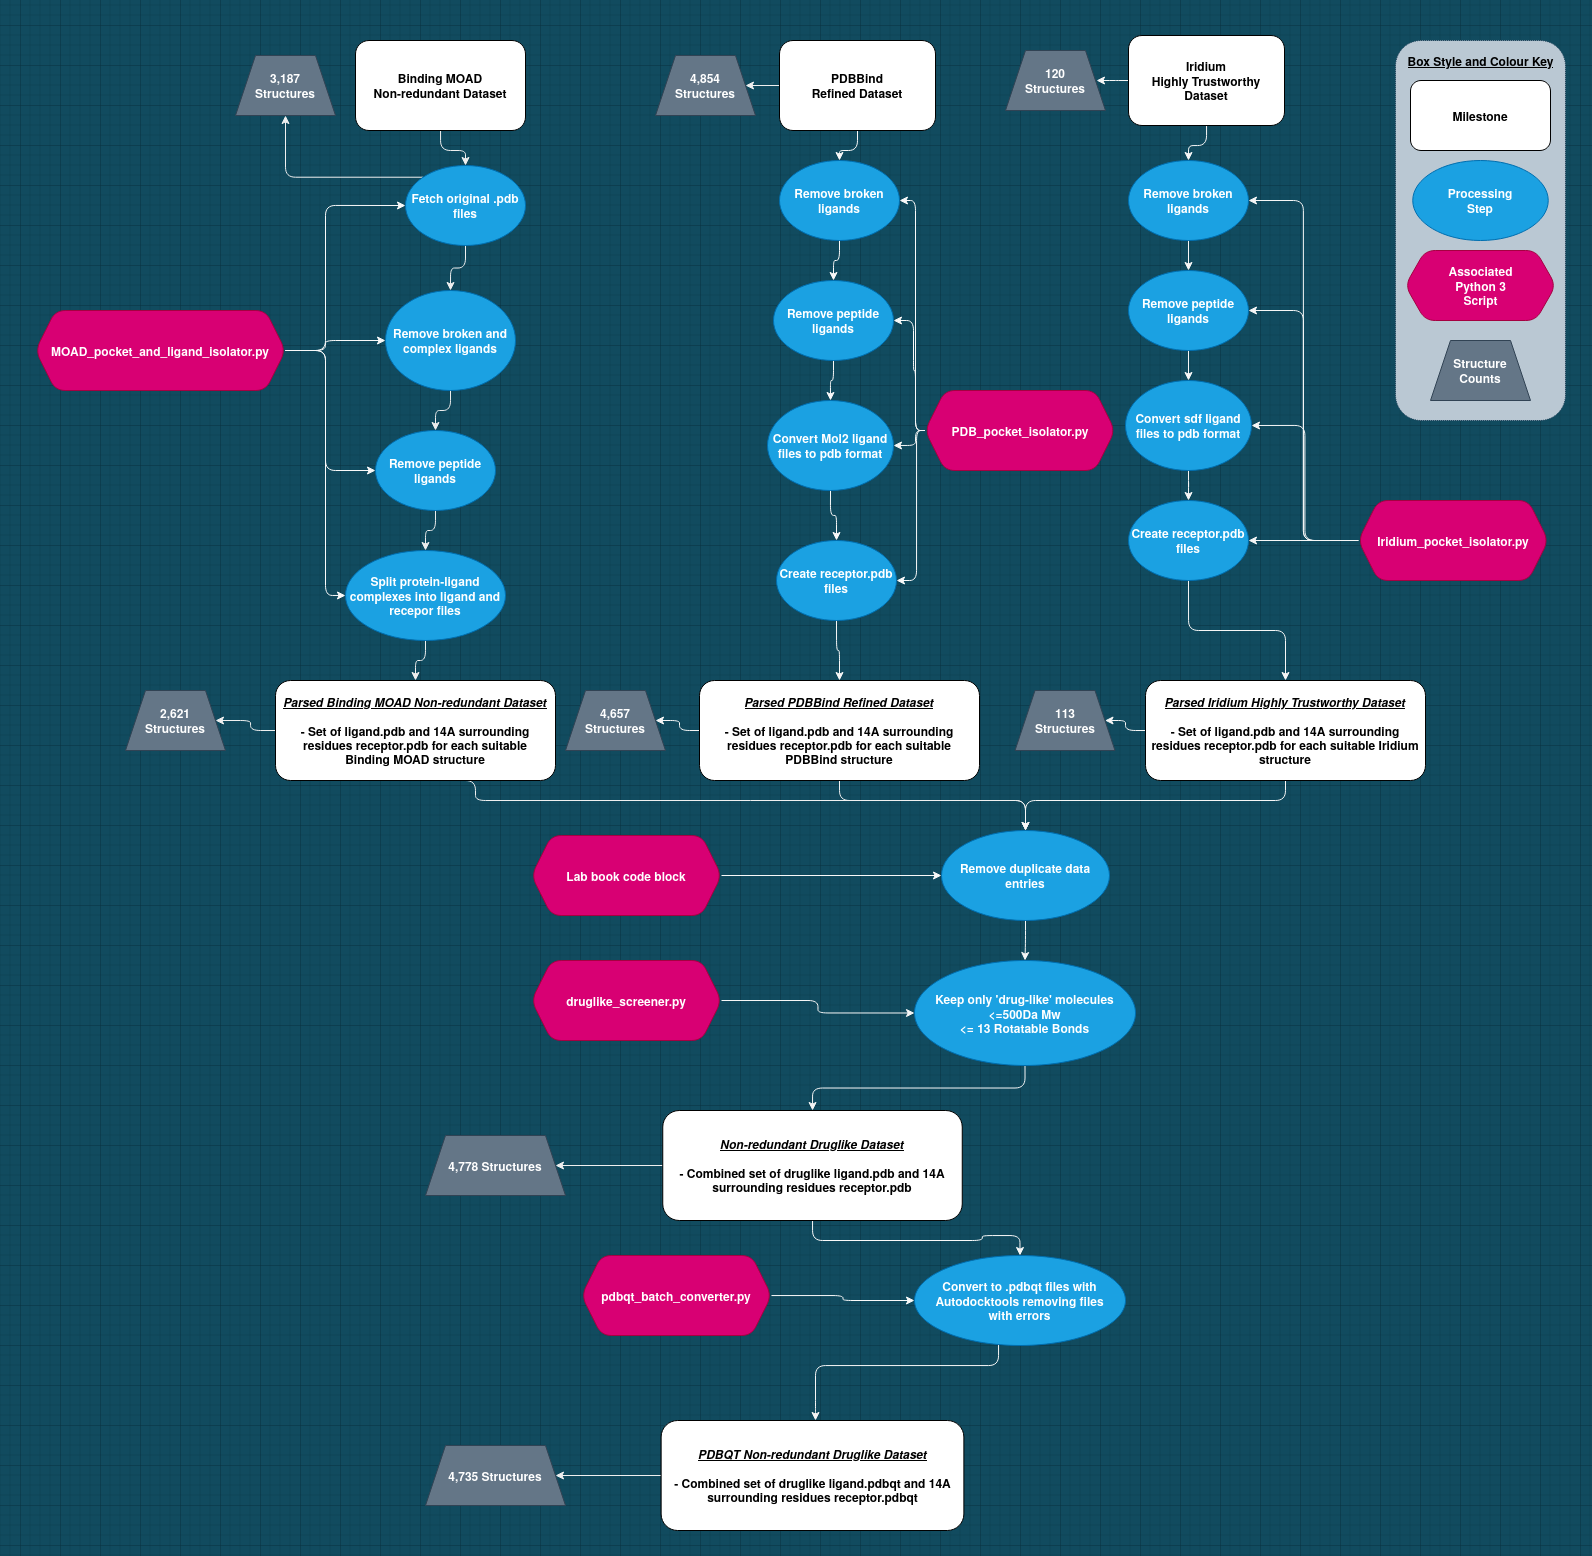

In [2]:
from IPython.display import Image
Image(filename="Images/data_cleaning.png")

*Figure 1 - Flowchart of planned data cleaning process*

## **Binding MOAD Data Cleaning**

### **Splitting Protein-Ligand Complexes**

The raw extracted Binding MOAD dataset just contains .pdb complex files, which need to be separated into a 'protein.pdb' file and a 'ligand.pdb' file. In .pdb files, amino acids/residues are stored as type 'ATOM', whereas non-amino acid residues are stored as type 'HETATM'. This 'HETATM' type includes sulfates, zincs and waters that are likely not ligands, as well as cofactors. 

I have written a script - 'MOAD_protein_and_ligand_isolator.py' - to perform the splitting of ligand and protein, trim unneccessary residues from the protein file and to deal with oligomers. The methodology for this is outlined below. This loads the binding data csv from Binding MOAD (the location of which is passed to the script by the -ref argument), and uses this to find the ID for the active ligand in the complex, then splits it and saves it separately from the protein, as well as stripping all the other HETATM types such as sulfates and waters. The script saves the protein in a 'receptor' file, which contains any atoms within an arbitary cutoff distance of the ligand. In this case, we use 14A as the receptor cutoff (this value is passed to the script with the -cutoff argument). This script produces a folder for each pdb file called '/home/milesm/Dissertation/Data/Parsed/Binding_MOAD/Successes/{pdb_code}'. When the script finds a structure that we don't want to keep, it saves it in a pre-defined 'problem_destination' so it can be manually verified if needed. Both the success and problem directories are set by the -suc and -prob arguments respectively.The raw pdb structure location is passed to the script with the -loc argument.

### **Structures kept and structures removed by protein_and_ligand_isolator.py:**

There is significant variation in how ligands are stored in their .pdb files when obtained from Binding MOAD. Below I will talk through three such complex examples, which ones we have kept and why, and which ones we have discarded and why, as well as the methodology for consistently acheiving this.

#### **_1. Single Ligand in a Single Binding Site_**

These are ideal structures, and we want to keep them. A good example is structure 5x13:

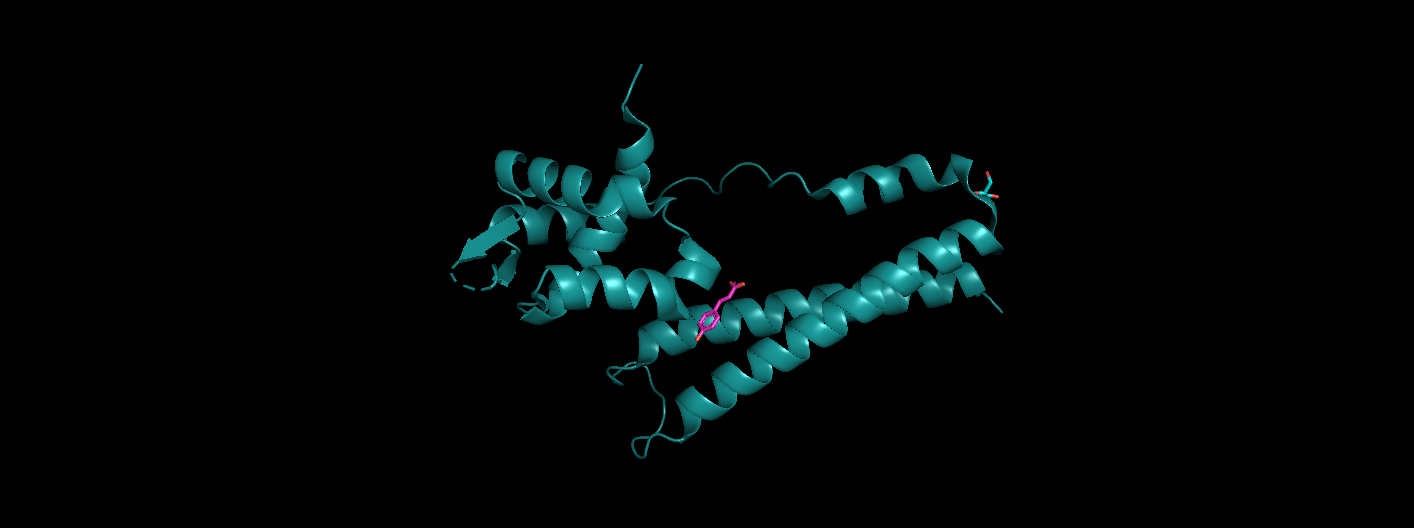

In [3]:
Image('Images/5x13_full.png')

This has one active ligand (pink) in one binding site - here the script creates a single .pdb file for the ligand, and another for the binding site/receptor, defined as any residue that has atoms within 14A of the ligand.  The output for 5x13 (saved as 5x13_receptor.pdb) looks like this:

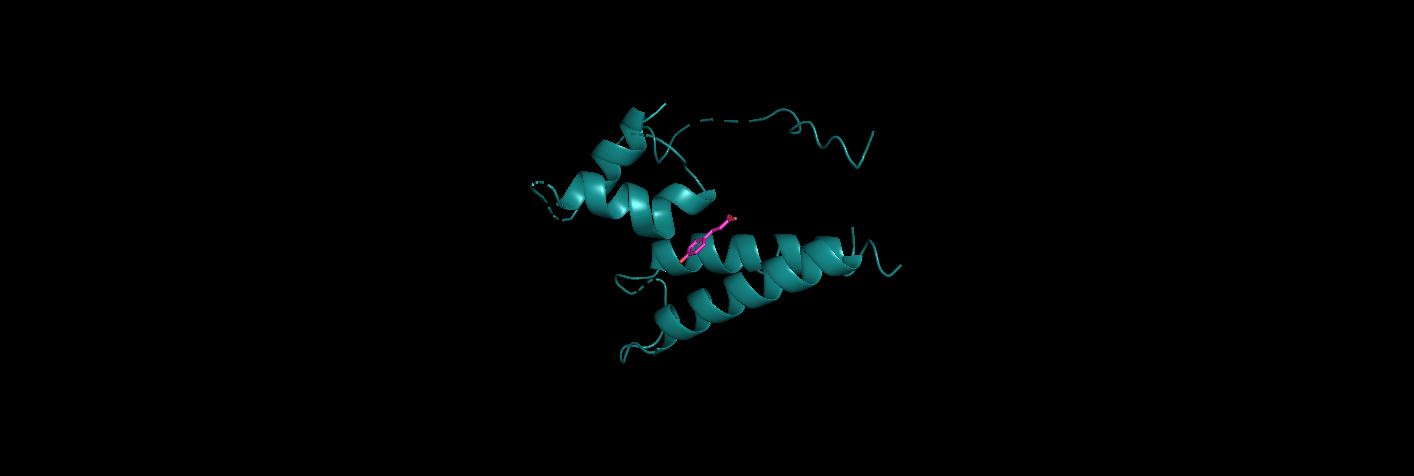

In [4]:
Image('Images/5x13_ligand.png')

#### **_2. Multiple Identical Ligands in Multiple Identical Binding Sites_**

In the case of multimer structures, often there are multiple occurences of the same ligand bound to multiple occurences of the same binding site. We want to keep these structures, as the Kd provided will be for the one ligand to the one binding site, and these multimers will be present due to crystallisation dynamics. An example of such a structure can be seen below in structure 2vc7:

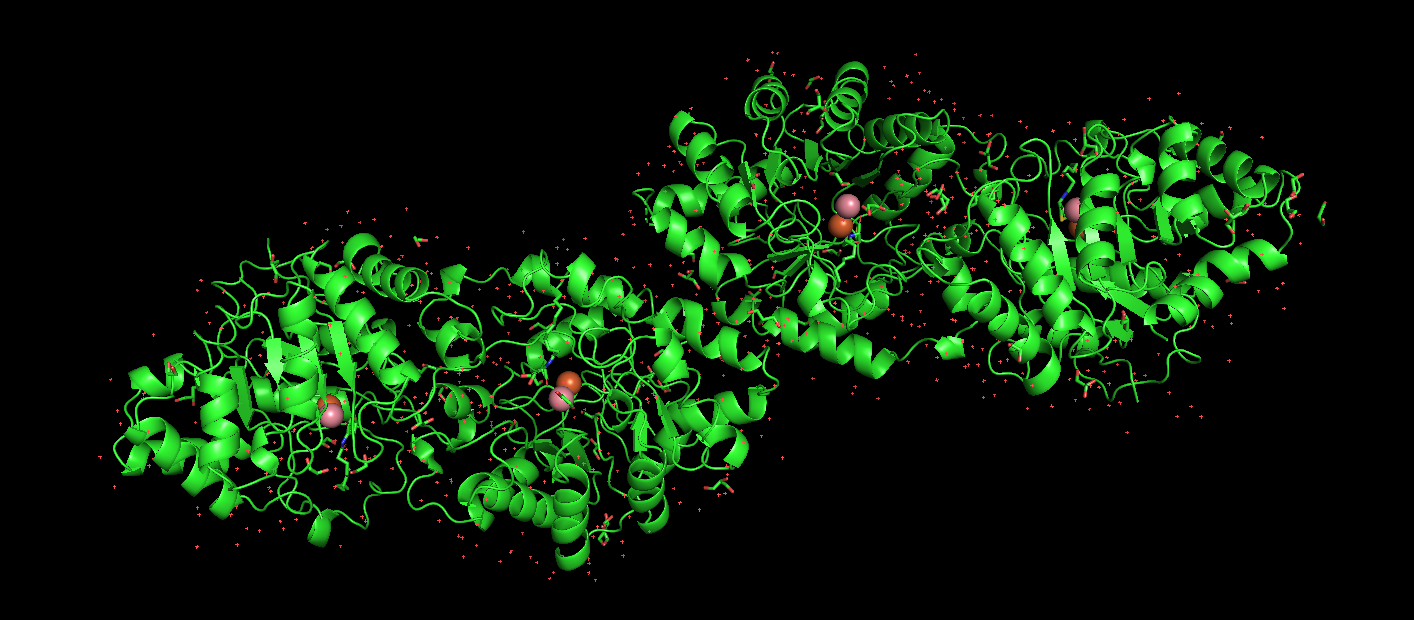

In [5]:
Image('Images/2vc7_full.png')

Note how the active ligands are identical, and so are the binding sites. There is also only one active ligand in each binding site:

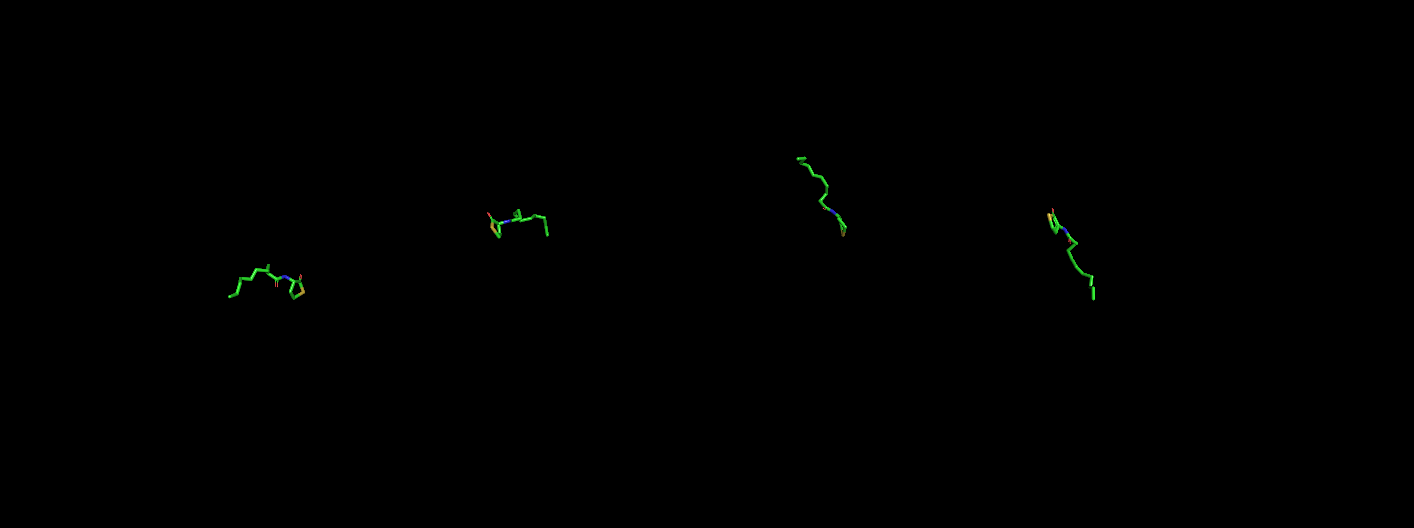

In [6]:
Image('Images/2vc7_ligands.png')

When dealing with structures like this, the script will pick one of the active ligands and save it, and then save any protein residues within 14 angstroms as 'receptor.pdb'. Below is the output (both the ligand and receptor file together) for this script for the above structure:

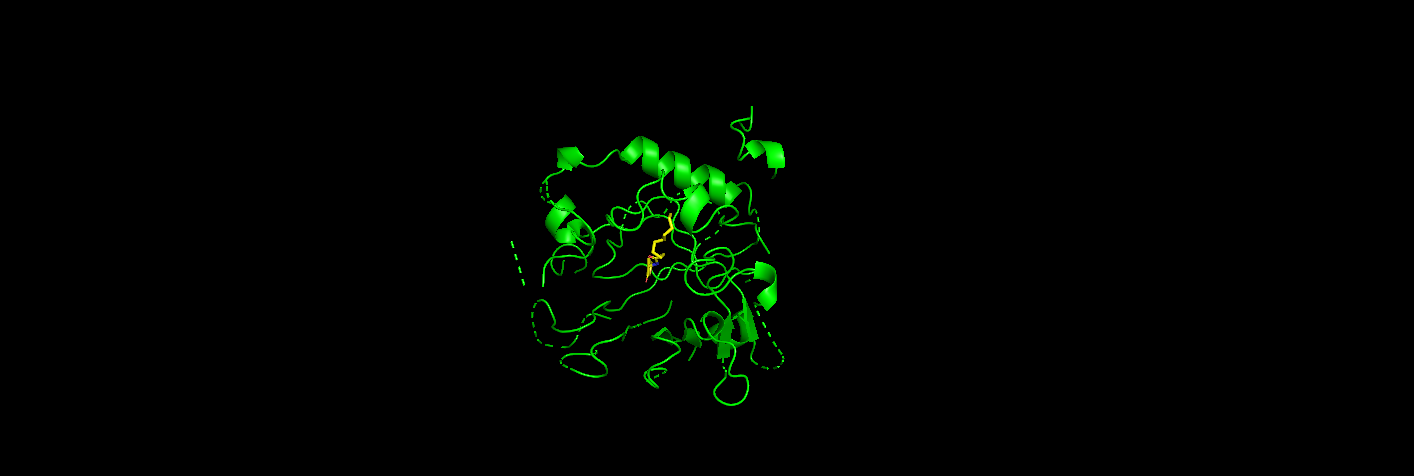

In [7]:
Image('Images/2vc7_output.png')

#### **_3. Multiple Ligands in a Single Binding Site_**

This is where the complexity arises. If we look at a structure like 1a0t, we can see that there are six identical ligands, bound to three binding sites. **We don't want to keep these structures, as there could be cooperative binding at play, and the binding kinetics could confuse our model that will be trying to predict the Kd of simple 1:1 binding reactions.** Therefore, the script also runs a check to see if any HETATMS from a **different chain** that **are not part of the protein** are **within 5 angstroms** of the active ligand (this 5A exclusion cuttoff is set in the scripts -exclusion argument). If it finds any, it does not keep the structure (So this structure would not be kept in the final dataset). 

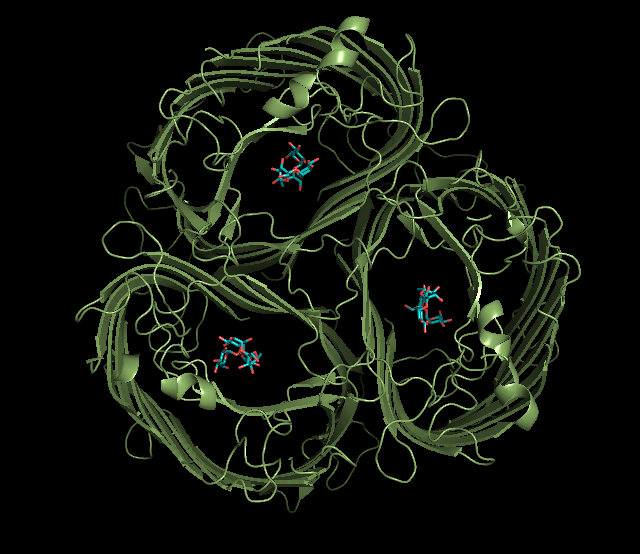

In [8]:
Image('Images/1a0t_full.png')

To add further complexity, if we look at the ligands specifically, we can see that each of these ligands are actually made up of a GLC (purple) residue bound to a FRU (blue) residue. In simple terms:
- Each ligand is on the same chain, so six chains in total
- Each ligand is made up of two residues, so twelve residues in total

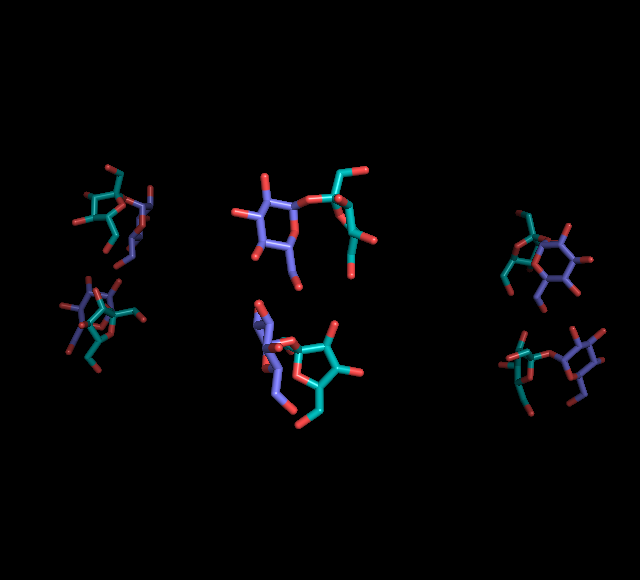

In [9]:
Image('Images/1a0t_ligands.png')

This leads us onto the third type of complex structure we encounter in the Binding MOAD dataset.

#### **_4. Multiple Ligands Stored as One Chain_**

I am not sure why these structures are included, but they are not a rare occurence in Binding MOADs non-redundant dataset. As an example, we will use 1ui0. It contains **two uracils** bound to **one protein** in **different binding sites**, for which a **single Kd value is given**:

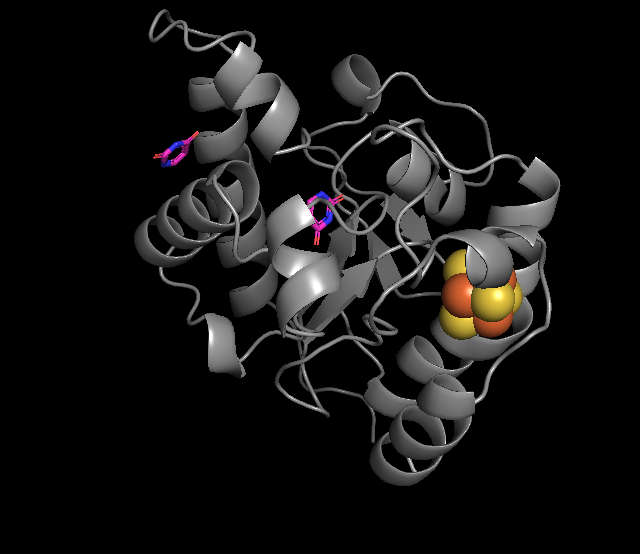

In [10]:
Image('Images/1ui0_full.png')

Looking closely again at the ligands, we can see that they are clearly not a single chain:

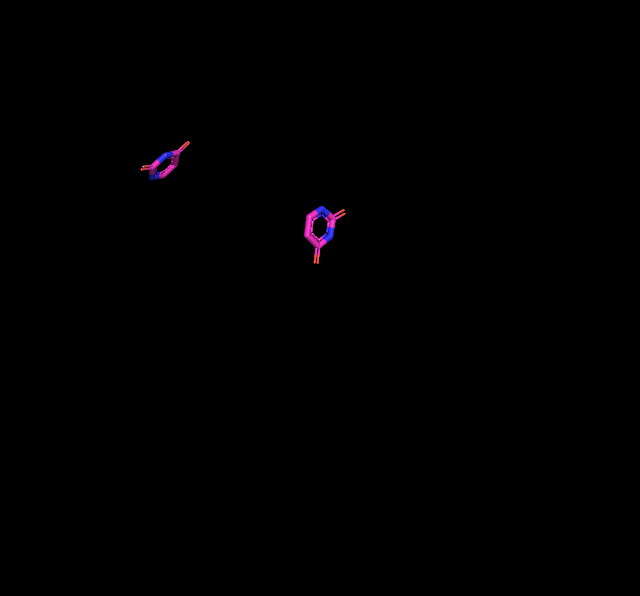

In [11]:
Image('Images/1ui0_ligand_only.png')

Yet when we look at the pdb file, we can see they are stored as:
- Two residues (211 and 212)
- One chain (A)

Just like the ligands in 1a0t:

In [ ]:
# TEXT FILE
HETATM 1527  N1  URA A 211      23.244   9.869  10.493  1.00  6.06           N  
HETATM 1528  C2  URA A 211      22.336   8.868  10.149  1.00  3.81           C  
HETATM 1529  O2  URA A 211      21.944   8.640   9.014  1.00  3.98           O  
HETATM 1530  N3  URA A 211      21.889   8.114  11.203  1.00  3.06           N  
HETATM 1531  C4  URA A 211      22.225   8.226  12.546  1.00  3.38           C  
HETATM 1532  O4  URA A 211      21.802   7.523  13.469  1.00  3.98           O  
HETATM 1533  C5  URA A 211      23.175   9.299  12.806  1.00  3.62           C  
HETATM 1534  C6  URA A 211      23.643  10.066  11.803  1.00  3.89           C  
HETATM 1535  N1  URA A 212      12.951  22.669  14.395  1.00 27.12           N  
HETATM 1536  C2  URA A 212      14.300  22.939  14.155  1.00 27.13           C  
HETATM 1537  O2  URA A 212      15.109  23.269  15.018  1.00 28.86           O  
HETATM 1538  N3  URA A 212      14.685  22.807  12.839  1.00 27.21           N  
HETATM 1539  C4  URA A 212      13.898  22.442  11.741  1.00 27.00           C  
HETATM 1540  O4  URA A 212      14.267  22.327  10.562  1.00 28.89           O  
HETATM 1541  C5  URA A 212      12.509  22.183  12.101  1.00 26.78           C  
HETATM 1542  C6  URA A 212      12.092  22.301  13.378  1.00 26.54           C  

Therefore, the script deals with 'Broken Ligands' such as these using Open Drug Discovery Toolkit and OpenBabel to check for a **shared bond between sequential residues in a ligand if a ligand has more than one residue**. Here, this ligand would fail the test, and the structure would be discarded. 1a0t would pass this test, but be discarded due to the proximity of another ligand in the same binding site.

#### **_5. Ligands Containing Amino Acids/Peptide Ligands_**

In this project, we are not looking to predict the affinities of peptide ligands. Therefore, **the residues in each ligand are verified to not be amino acids**. If amino acids are found in the ligand, the structure is discarded. Take as an example structure 1b7h, which at first glance is ideal for our purposes:

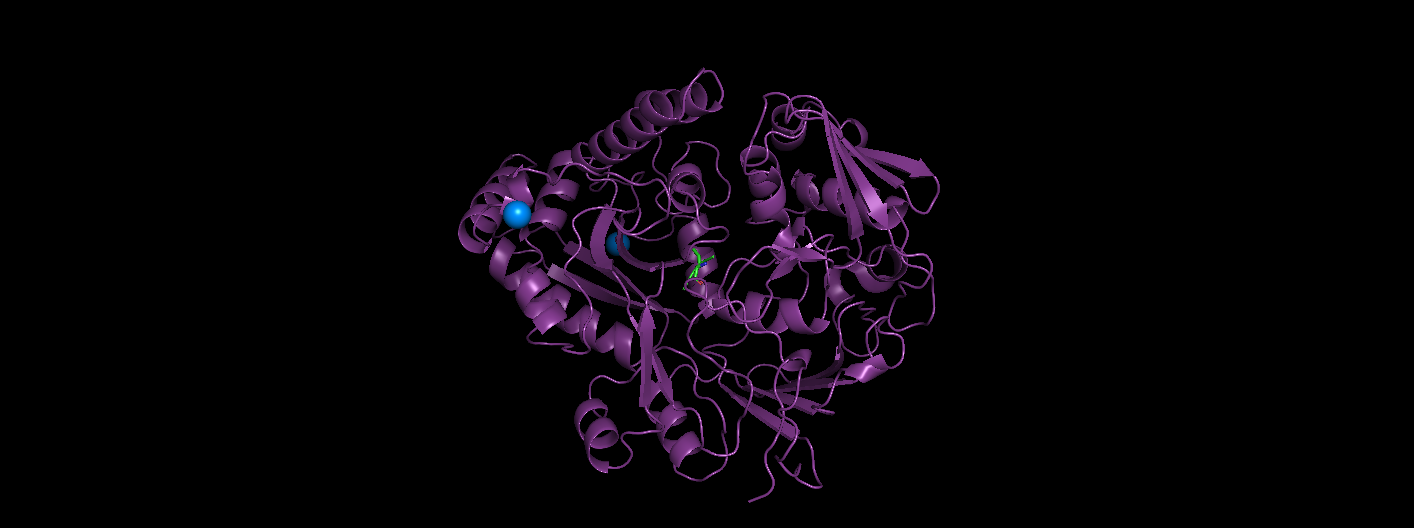

In [12]:
Image('Images/1b7h_full.png')

Examining the structure, we can see that the ligand is a conjugate of an Lysines and HETATMS:

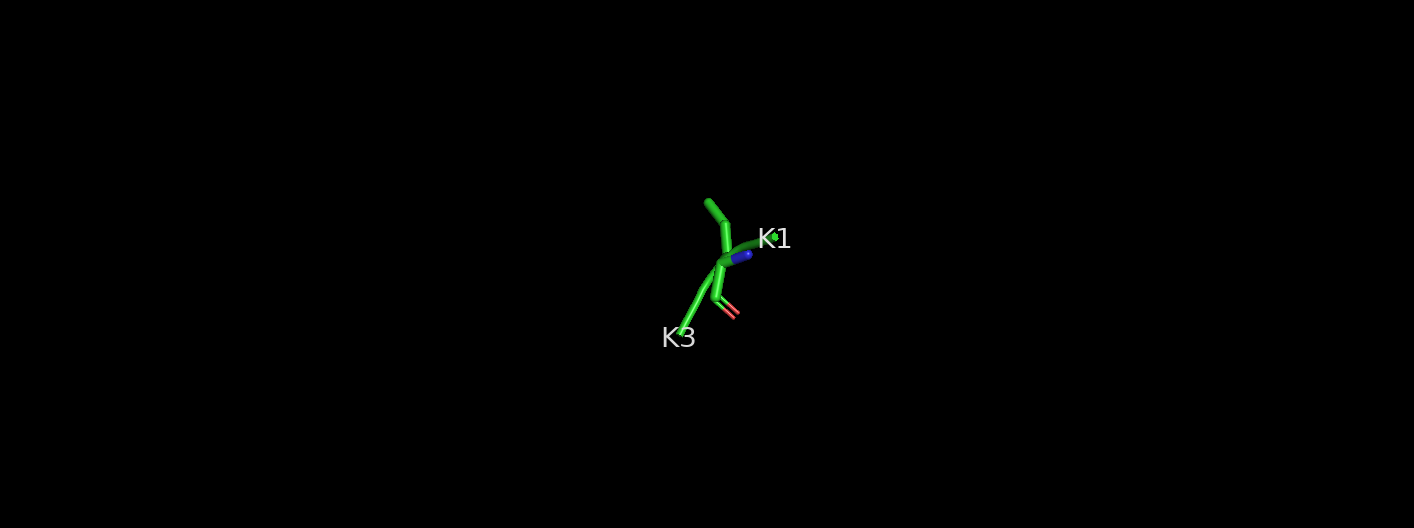

In [13]:
Image('Images/1b7h_ligand.png')

Here, the script would not keep this structure, and it would again be copied to the problems directory if verification was needed. After all the structures have been run through this script, we are left with a library of ligand and receptor files that should suit our purposes perfectly. 

#### **Running MOAD_protein_and_ligand_isolator.py**

**Arguments**
- **-loc** /path/to/raw/structure/folders
- **-suc** /path/to/save/successful/structures
- **-prob** /path/to/save/problem/structures
- **-ref** /path/to/MOAD/binding/data/csv 
- **-cutoff** value in angstroms for how close a residue has to be to the ligand to be included in 'receptor.pdb'
- **-exclusion** value in angstroms for how far away the ligand has to be from any other ligands to be included as a successful structure

An example command line usage would be:
- python3 MOAD_protein_and_ligand_isolator.py -loc /path/to/structure/folders -suc /path/to/save/successful/structures -prob /path/to/save/problem/structures -ref /path/to/binding/data/csv -cutoff 14 -exclusion 5

The exact command run to produce these files was as follows (newlines have been added for clarity of arguments):

In [ ]:
# UNIX CODE
python3 MOAD_pocket_and_ligand_isolator.py 
-loc /home/milesm/Dissertation/Data/Raw/Binding_MOAD/original_PDB_files/ 
-suc /home/milesm/Dissertation/Data/Parsed/Binding_MOAD/Successes/ 
-prob /home/milesm/Dissertation/Data/Parsed/Binding_MOAD/Problems/ 
-ref /home/milesm/Dissertation/Data/Raw/Binding_MOAD/Compressed/nr_bind.csv 
-cutoff 14 
-exclusion 5

## **PDBBind Data Cleaning**

The PDBBind Database ships in close to the ideal format for this project. However, the ligand files are supplied in 'mol2' and 'sdf' format, but not in .pdb format. The dataset also includes peptide ligands, and does not supply the 'receptor' type format we want (all the protein residues within 14A of the ligand). It does supply a 'pocket.pdb' file, but this has a much lower cutoff value of around 6/7A. 

To solve this, I have written a script called 'PDB_pocket_isolator.py'. This script loads in the 'sdf' format ligand from the structure folder and makes a .pdb copy of it in the raw data location. It then loads this .pdb ligand, and the protein.pdb file in the same folder. It:

- removes all waters from the protein file
- checks for amino acids in the ligand
- checks for broken ligands as above in the MOAD cleaning steps using the same functions
- If the ligand passes these checks, the script finds all the residues in the 'protein.pdb' file that have any atom within 14A (again, this is passed to script under the -cutoff argument), and then saves all these residues in a 'receptor.pdb' file

A worked example of this can be seen with the structure 1a28. Below we can see what PDBBind supplies - the ligand.mol2 file open with the protein.pdb file in PyMOL:

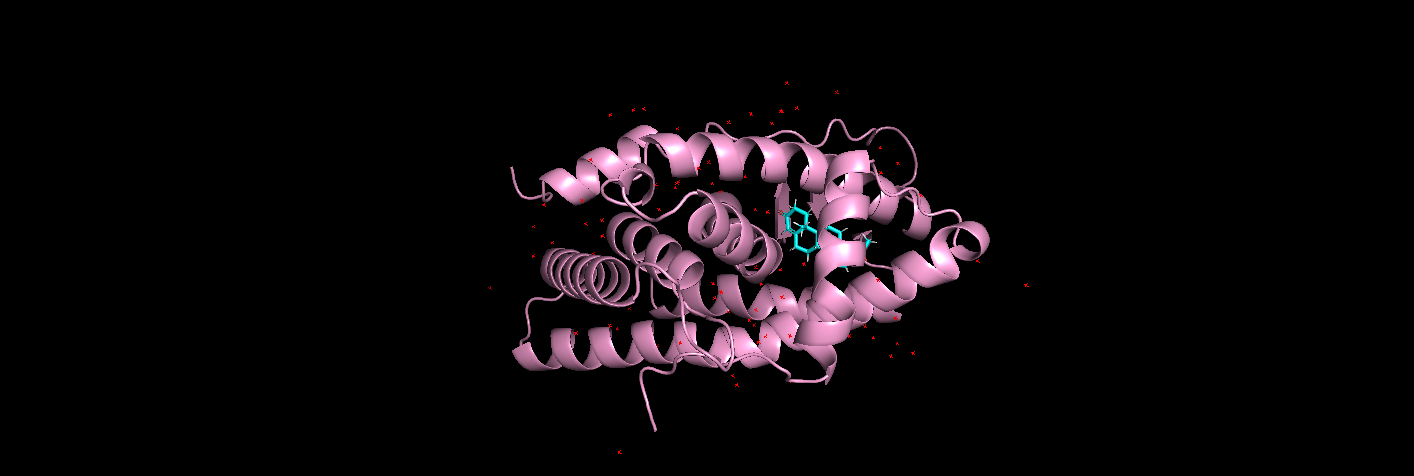

In [14]:
Image('Images/1a28_pdbbind.png')

Alternatively, PDBBind also ships with a 'pocket.pdb' file which we can see below open with the ligand file:

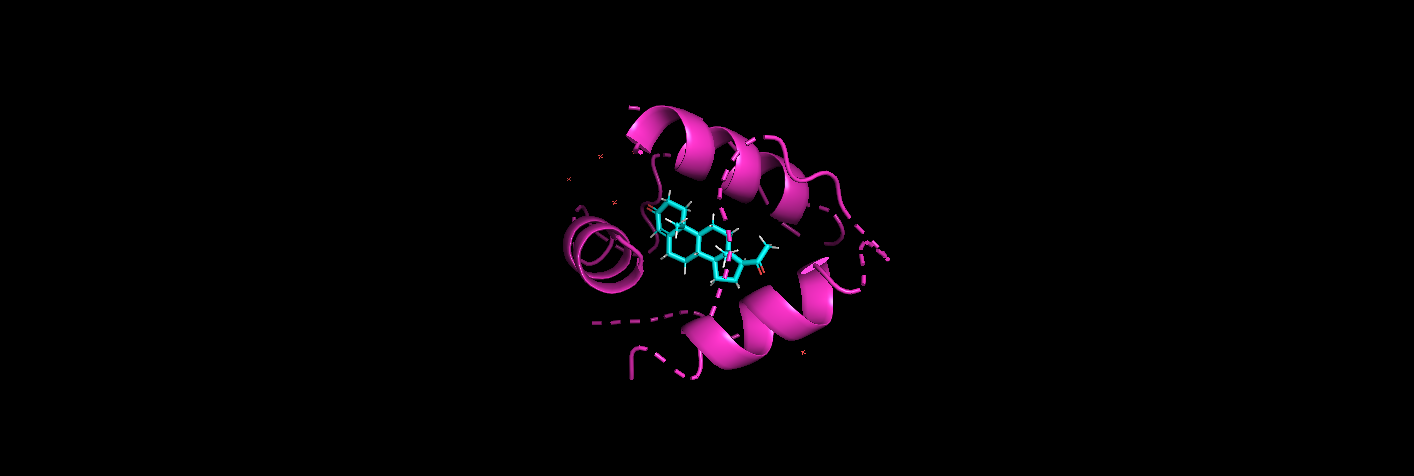

In [15]:
Image('Images/1a28_pocket.png')

https://www.eyesopen.com/database-iridiumThis pocket file is very useful to have, but to ensure our data and structures are completely standardised, we are using a 14A cutoff for both PDBBind and Binding_MOAD. The structure above also still contains water molecules, which we need to remove. See below the output of the 'PDB_pocket_isolator.py' script - this is the 'ligand.pdb' and 'receptor.pdb' files open together for structure 1a28:

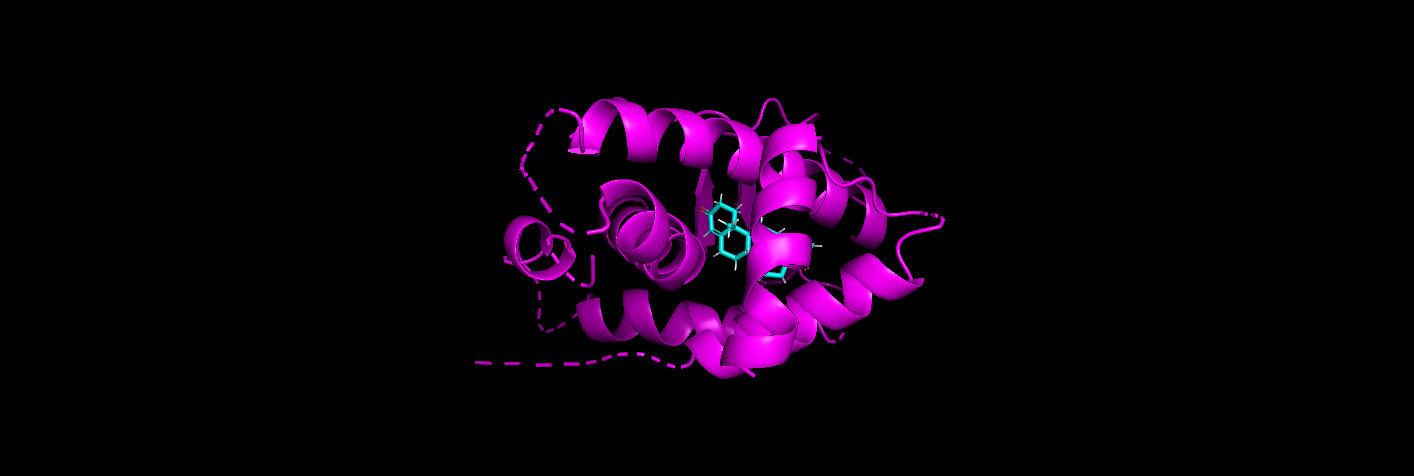

In [16]:
Image('Images/1a28_receptor.png')

#### **Running PDB_pocket_isolator.py**


**Arguments**
- **-loc** /path/to/raw/structure/folders
- **-suc** /path/to/save/successful/structures
- **-prob** /path/to/save/problem/structures
- **-cutoff** value in angstroms for how close a residue has to be to the ligand to be included in 'receptor.pdb'

An example command line usage would be:
- python3 PDB_pocket_isolator.py -loc /path/to/PDBBind/structure/folders -suc /path/to/save/successes/ -prob /path/to/save/problems/ -cutoff 14

The exact command I used to run this script is as follows (again with newlines added between arguments for clarity):

In [ ]:
# UNIX CODE
python3 PDB_pocket_isolator.py 
-loc /home/milesm/Dissertation/Data/Raw/PDBBind/Extracted/refined-set/ 
-suc /home/milesm/Dissertation/Data/Parsed/PDBBind/Successes/ 
-prob /home/milesm/Dissertation/Data/Parsed/PDBBind/Problems/ 
-cutoff 14

## **Iridium Data Cleaning**

Iridium comes in a similar format to PDBBind - with supplied separated protein and ligand files. There are multiple versions of the files which have bee subject to different amounts of refinement. Here, I have used only the structures from the highly trustworthy **Iridium HT** dataset, as other versions contain covalently bound ligands. All structures were then taken from the '/Deposited' folder, with the ligand being sourced from 'XXXX_deposited_refined_lig.sdf' and the protein sourced from 'XXXX_deposited_refined_prot.pdb'. The script Iridium_pocket_isolator.py was adapted form PDB_pocket_isolator.py and is used to clean these structures to the standard 14A receptor with no waters .pdb file and a ligand.pdb file. It works in exactly the same way as PDB_pocket_isolator.py, just adapted to work with the different filestructure and nomenclature of the Iridium dataset.

#### **Running Iridium_pocket_isolator.py**


**Arguments**
- **-loc** /path/to/raw/structure/folders
- **-suc** /path/to/save/successful/structures
- **-prob** /path/to/save/problem/structures
- **-cutoff** value in angstroms for how close a residue has to be to the ligand to be included in 'receptor.pdb'

An example command line usage would be:
- python3 Iridium_pocket_isolator.py -loc /path/to/Iridium-HT/structure/folders -suc /path/to/save/successes/ -prob /path/to/save/problems/ -cutoff 14

The exact command I used to run this script is as follows (again with newlines added between arguments for clarity):

In [ ]:
# UNIX CODE
python3 Iridium_pocket_isolator.py 
-loc /home/milesm/Dissertation/Data/Raw/Iridium/Iridium/iridium-HT/deposited/ 
-suc /home/milesm/Dissertation/Data/Parsed/Iridium/Successes/ 
-prob /home/milesm/Dissertation/Data/Parsed/Iridium/Problems/ 
-cutoff 14

## **Removing Duplicate Data Entries**

Since PDBBind and Iridium ship in the ideal format, and Iridium structures are refined and checked the most thoroughly, the order of preference for keeping structures in the case of duplicates is as follows:

1. Iridium Structures
2. PDBBind Structures
3. Binding MOAD Structures

The duplicates can be stripped and the full non-redundant set copied using some very simple python3 code:

In [ ]:
import os
import shutil
from tqdm import tqdm
import time

pdbbind_structures = os.listdir('/home/milesm/Dissertation/Data/Parsed/PDBBind/Successes')

binding_MOAD_structures = os.listdir('/home/milesm/Dissertation/Data/Parsed/Binding_MOAD/Successes')

iridium_structures = os.listdir('/home/milesm/Dissertation/Data/Parsed/Iridium/Successes')

pdbbind_clean_structures = [structure for structure in pdbbind_structures]
binding_MOAD_clean_structures = [structure for structure in binding_MOAD_structures]
iridium_clean_structures = [structure for structure in iridium_structures]

pdbbind_exclusives = list()
MOAD_exclusives = list()

for structure in pdbbind_clean_structures:
    if structure not in iridium_clean_structures:
        pdbbind_exclusives.append(structure)

for structure in binding_MOAD_clean_structures:
    if structure not in iridium_clean_structures:
        if structure not in pdbbind_clean_structures:
            MOAD_exclusives.append(structure)

print(f'{len(iridium_clean_structures)} structures from Iridium')
print(f'{len(pdbbind_exclusives)} structures from PDBBind')
print(f'{len(MOAD_exclusives)} structures from Binding MOAD')

time.sleep(1)

os.mkdir('/home/milesm/Dissertation/Data/Parsed/Non_redundant')
os.mkdir('/home/milesm/Dissertation/Data/Parsed/Non_redundant/PDBBind')
os.mkdir('/home/milesm/Dissertation/Data/Parsed/Non_redundant/Binding_MOAD')
os.mkdir('/home/milesm/Dissertation/Data/Parsed/Non_redundant/Iridium')
os.mkdir('/home/milesm/Dissertation/Data/Parsed/Non_redundant/Full')

iridium_structures_filepaths = [f'/home/milesm/Dissertation/Data/Parsed/Iridium/Successes/{file}' for file in iridium_clean_structures]
pdbbind_exclusive_structures_filepaths = [f'/home/milesm/Dissertation/Data/Parsed/PDBBind/Successes/{file}' for file in pdbbind_exclusives]
binding_MOAD_exclusive_structures_filepaths = [f'/home/milesm/Dissertation/Data/Parsed/Binding_MOAD/Successes/{file}' for file in MOAD_exclusives]

with tqdm(total=len(iridium_structures_filepaths)) as pbar:
    for filepath in iridium_structures_filepaths:
        filename = filepath.split('/')[len(filepath.split('/')) - 1]
        shutil.copytree(filepath, f'/home/milesm/Dissertation/Data/Parsed/Non_redundant/Iridium/{filename}')
        shutil.copytree(filepath, f'/home/milesm/Dissertation/Data/Parsed/Non_redundant/Full/{filename}')
        pbar.update(1)

with tqdm(total=len(pdbbind_exclusive_structures_filepaths)) as pbar:
    for filepath in pdbbind_exclusive_structures_filepaths:
        filename = filepath.split('/')[len(filepath.split('/')) - 1]
        shutil.copytree(filepath, f'/home/milesm/Dissertation/Data/Parsed/Non_redundant/PDBBind/{filename}')
        shutil.copytree(filepath, f'/home/milesm/Dissertation/Data/Parsed/Non_redundant/Full/{filename}')
        pbar.update(1)

with tqdm(total=len(binding_MOAD_exclusive_structures_filepaths)) as pbar:
    for filepath in binding_MOAD_exclusive_structures_filepaths:
        filename = filepath.split('/')[len(filepath.split('/')) - 1]
        shutil.copytree(filepath, f'/home/milesm/Dissertation/Data/Parsed/Non_redundant/Binding_MOAD/{filename}')
        shutil.copytree(filepath, f'/home/milesm/Dissertation/Data/Parsed/Non_redundant/Full/{filename}')
        pbar.update(1)

## **Keeping only 'Drug-like' Molecules**

This step is performed by the script 'druglike_screener.py'. **Here, our defenition of 'Druglike' is less than 500Da Mw, and <= 13 rotatable bonds.** The script iteratively loads each of the ligand.pdb or ligand.mol2 files from the folder /home/milesm/Dissertation/Data/Parsed/Non_redundant/Full/ and subjects them to a series of filters as defined below. If the ligand passes, the whole folder and its contents are copied to the destination path, in this case /home/milesm/Dissertation/Data/Parsed/Non_redundant/Full_Druglike/

### **Molecular Weight under 500Da**

Openbabel's .molwt function is used to calculate the molecular weight of each ligand. If less than 500, it passes this criteria.

### **Rotatable Bonds <= 13**

Again, the exact same methodology is used as for molecular weight, except the .molwt function is substituted for .num_rotors.

#### **Running druglike_screener.py**

**Arguments**
- **-loc** /path/to/parsed/structure/folders
- **-des** /path/to/save/druglike/structure/folders
- **-mw** threshold for maximum molecular weight - evaluated with <= by the script for inclusion
- **-rot** threshold for maximum molecular weight - evaluated with <= by the script for inclusion

An example command line usage would be:
- python3 druglike_screener.py -loc /path/to/parsed/structure/folders -des /path/to/save/druglike/structure/folders -mw 500 -rot 13

The exact command I used to run this script is as follows (again with newlines added between arguments for clarity):

In [ ]:
# UNIX CODE
python3 druglike_screener.py
-loc /home/milesm/Dissertation/Data/Parsed/Non_redundant/Full/
-des /home/milesm/Dissertation/Data/Parsed/Non_redundant/Full_Druglike/
-mw 500
-rot 13

## **Conversion from .pdb to .pdbqt using Autodocktools**

All the datasets should now be in the same ligand.pdb and protein.pdb format, with duplicates removed, in the 'Dissertation/Data/Parsed/Non_redundant/Full_Druglike' folder. The next step is to convert these pdb files into pdbqt files using autodocktools. This is a command line process. Autodocktools ships with two python scripts:

In [ ]:
# UNIX CODE
MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24/prepare_ligand4.py
MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24/prepare_receptor4.py

These scripts convert pdb files to pdbqt files. Here, I will use the following commands to convert the pdb files to pdbqt files:

For the ligand pdb file, this command adds polar hydrogens and gasteiger charges:

In [ ]:
# UNIX CODE
- prepare_ligand4.py -l ligand.pdb -A hydrogens -o ligand.pdbqt -U nphs

For the protein pdb file, this command also adds polar hydrogens and gasteiger charges:

In [ ]:
# UNIX CODE
- prepare_receptor4.py -r protein.pdb -A hydrogens -o protein.pdbqt -U nphs

I have written a python 3 script 'pdbqt_batch_converter.py' which takes all the protein and ligand pdb files in the 'Dissertation/Data/Parsed/Non_redundant/Full_Druglike' folder, converts them using the autodocktools command line commands above and then saves them in the 'Dissertation/Data/PDBQT/Non-redundant/' folder. It also produces a text file of structure names which caused errors when trying to be converted called 'fatal_errors_list.txt', and saves these files in a defined problem directory like in the other data cleaning scripts. It has been pushed to the project github.

#### **Running pdbqt_batch_converter.py**

**Arguments**
- **-loc** /path/to/parsed/druglike/structure/folders
- **-suc** /path/to/save/pdbqt/structure/folders
- **-prob** /path/to/save/problem/pdbqt/structure/folders
- **-prep_lig** /command/to/run/autodocktools/prepare_ligand4.py
- **-prep_prot** /command/to/run/autodocktools/prepare_receptor4.py
- **-threads** int(number of threads to parallelize over, only pass to multithread version)

An example command line usage would be:
- python3 pdbqt_batch_converter.py -loc /path/to/parsed/druglike/structure/folders -suc /path/to/save/pdbqt/structure/folders -prob /path/to/save/problem/pdbqt/structure/folders -prep_lig /command/to/run/autodocktools/prepare_ligand4.py -prep_prot /command/to/run/autodocktools/prepare_receptor4.py

For much faster processing, I have also written a multiproccessed version of the script for use on multicore machines. I have used this script, **which takes exactly the same arguments and performs exactly the same task in the same way, just parallelized over multiple threads**. 

The exact command I used to run this script is as follows (again with newlines added between arguments for clarity):

In [ ]:
# UNIX CODE
python3 multithread_pdbqt_batch_converter.py
-loc /home/milesm/Dissertation/Data/Parsed/Non_redundant/Full_Druglike/ 
-suc /home/milesm/Dissertation/Data/PDBQT/Non_redundant/Druglike/
-prob /home/milesm/Dissertation/Data/PDBQT/Non_redundant/Problem_Structures/ 
-prep_lig /home/milesm/Dissertation/Third_Party_Code/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24/prepare_ligand4.py 
-prep_prot /home/milesm/Dissertation/Third_Party_Code/MGLTools-1.5.6/MGLToolsPckgs/AutoDockTools/Utilities24/prepare_receptor4.py
-threads 4

<a id='decoy_generation_and_docking'></a>
# **Decoy Generation and Docking**

## Software Installations

#### **GWOVina**

This is the docking software we will be using to dock our decoys. The tarball file was downloaded from [Sourceforge](https://sourceforge.net/projects/gwovina/files/latest/download) and the following commands run:

In [ ]:
# UNIX CODE
tar -xf /home/milesm/Dissertation/Third_Party_Code/gwovina-1.0.tar.gz
cd /home/milesm/Dissertation/Third_Party_Code/gwovina-1.0/build/linux/release
sudo make

#### **DeepCoy**

This is a deep-learning based decoy generation program. [The github](https://github.com/fimrie/DeepCoy) was cloned to obtain the code. Pre-trained models were obtained from the [OxPIG Resources Page.](http://opig.stats.ox.ac.uk/resources)

#### **RdKit**

This installation is **very complex, and took a huge amount of trial and error**. What ended up working was a tweaked version of the [guide published by OxPIG](https://www.blopig.com/blog/2013/02/how-to-install-rdkit-on-ubuntu-12-04/). This is exactly how I installed it on my machine:

First, install all the dependencies:

In [ ]:
# UNIX CODE
sudo apt-get install flex bison build-essential python-numpy cmake python-dev sqlite3 libsqlite3-dev libboost-dev  libboost-python-dev libboost-regex-dev libfreetype6-dev

Then, cd into /opt (it seemed to be important that this was the folder it was installed in - the installation didn't work in other folders) and clone the current rdkit into this directory:

In [ ]:
# UNIX CODE
cd /opt
sudo git clone https://github.com/rdkit/rdkit.git

Then, we need to define all the environmental variables for the install in our ~/.bashrc file:

In [ ]:
# UNIX CODE
sudo nano ~/.bashrc

And add these lines to the bottom of the file:

In [ ]:
# UNIX CODE
export RDBASE=/opt/rdkit
export LD_LIBRARY_PATH=$RDBASE/lib:$LD_LIBRARY_PATH
export PYTHONPATH=$RDBASE:$PYTHONPATH

Then save it and close it, and resource your bash file using:

In [ ]:
# UNIX CODE
. ~/.bashrc

Then cd into the below directory in the $RDBASE file we defined in the bashrc file and run the specified bash script:

In [ ]:
# UNIX CODE
cd $RDBASE/External/INCHI-API/
sudo ./download-inchi.sh

Then close the terminal, open a new terminal and cd into the $RDBASE again, then make a build folder and cd into that:

In [ ]:
# UNIX CODE
cd $RDBASE
sudo mkdir build && cd build

Then run cmake:

In [ ]:
# UNIX CODE
sudo cmake -DRDK_BUILD_INCHI_SUPPORT=ON -DPYTHON_EXECUTABLE=/usr/bin/python3 ..

And finally make (where X is the number of threads your machine can run - this takes a while) and then make install:

In [ ]:
# UNIX CODE
sudo make -jX
sudo make install

## **General Approach**

Due to the conclusions from [this paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0220113) I have decided to not to use the commonly included DUD-E database at all in the project. The remarks by the authors are fairly damning:

_""We find that the high performance of CNN models trained on DUD-E is not attributable to having learned the features of protein-ligand interactions but rather to analogue and decoy bias inherent in the DUD-E dataset. We show that it is incorrect to infer that a model has successfully learned protein-ligand interactions solely on the basis of its high performance on a test set. Due to the hidden biases in the DUD-E dataset that we describe in this work, one should be very cautious when using DUD-E for machine learning based methodology development."_

Therefore, the following approach will be taken in this project for decoy generation:

1. Get experimentally verified real decoys from [LIT-PCBA](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00155) if there are any present for that ligand-receptor complex (LIT-PCBA is a database of experimentally verified actives and inactives compiled from PubChem binding assay data). As likely as it is that computationally generated decoys do not bind, we cannot say for certain that computer generated molecules would have no interaction. Using experimentally verified inactives where possible gives the least chance of including accidental/novel binders as decoys.
    
    
2. If not, generate our own using [DeepCoy](https://academic.oup.com/bioinformatics/advance-article-abstract/doi/10.1093/bioinformatics/btab080/6126797?redirectedFrom=fulltext), which is a Deep Learning powered decoy generator that seems to eliminate bias in decoy generation (or at least produce less biased decoys according to comparisons against DUD-E).

3. Dock whichever decoys we've come up with to the structure receptor file.

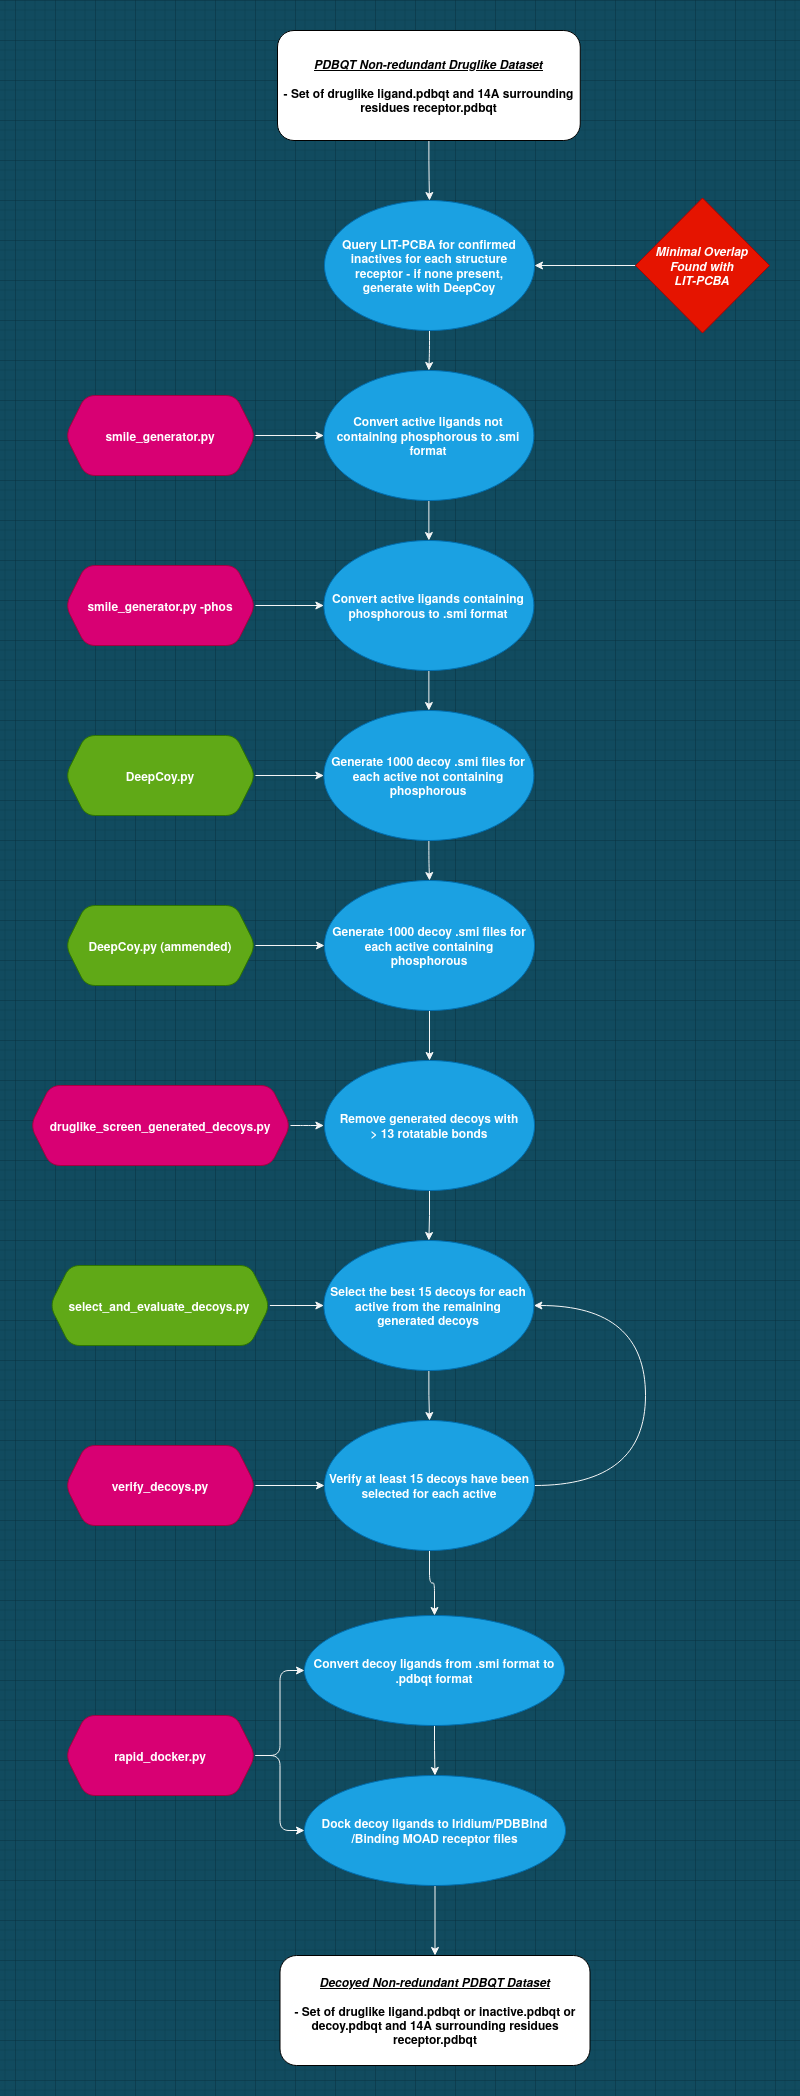

In [3]:
Image('Images/decoy_generation.png')

*Green denotes third party python scripts not written by myself*

### **Querying LIT-PCBA for Experimentally Verified Inactives**

LIT-PCBA actives are labelled with receptor names. Inactives (and actives) are supplied in a .smi or SMILES format, which is a written form of a molecule that conveys 3D bond information. For example, the ligand from structure 5l2o below:Experimentally

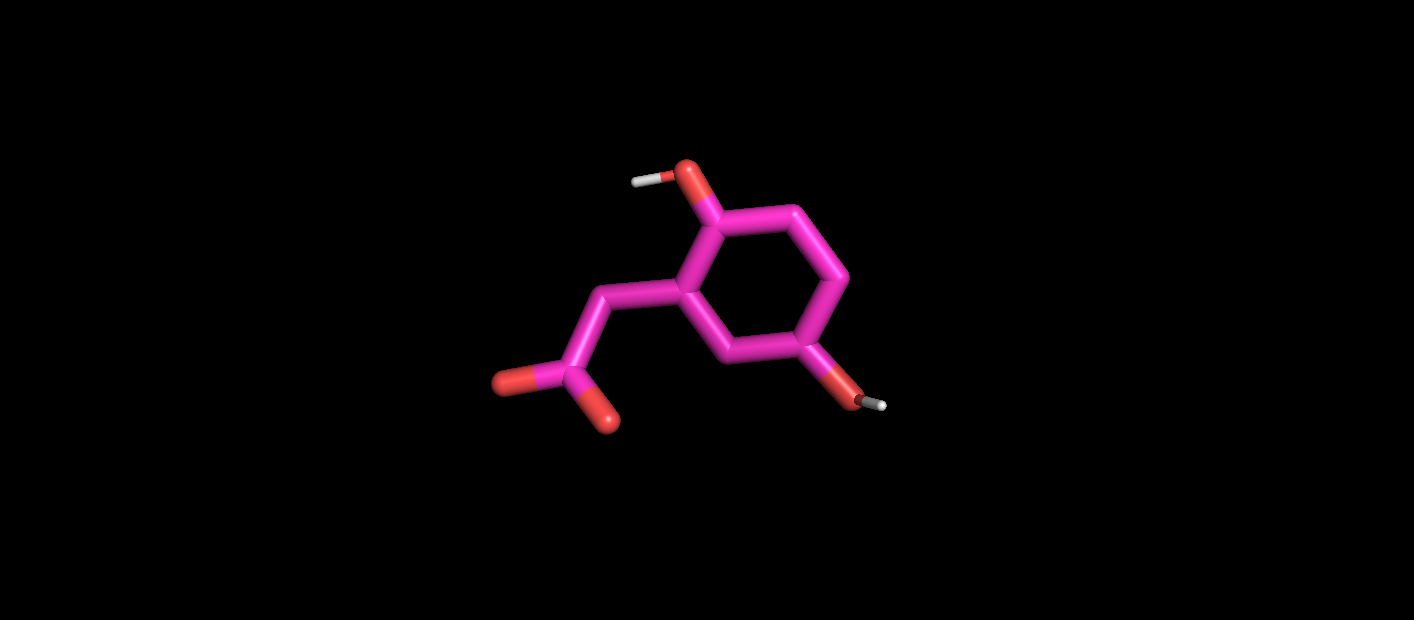

In [18]:
Image('Images/1ajp_ligand.png')

Can be represented in .smi format like this:

In [ ]:
# TEXT FILE
[C](/C(=[C]/O)/O)(O)[C](O)[C]OP(=O)([O])[O]

As all the actives and inactives in LIT-PCBA are stored in their receptor folders, we need to find the names of the proteins in our crystal structures, then match them to the receptors in the LIT-PCBA database. To do this, we can query the PDB API for protein information based on all our structure PDB codes using the PyPDB wrapper, then check for verified inactives in that receptor folder. If the receptor has no inactives in LIT-PCBA, we can use DeepCoy command line to generate our own decoys for that receptor.

Upon putting this into practice, it became clear that LIT-PCBA and our dataset had extremely minmal overlap:

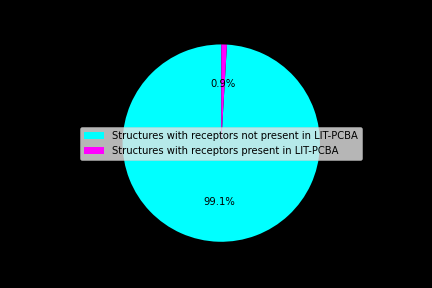

In [19]:
Image('Images/LIT_PCBA_overlap.png')

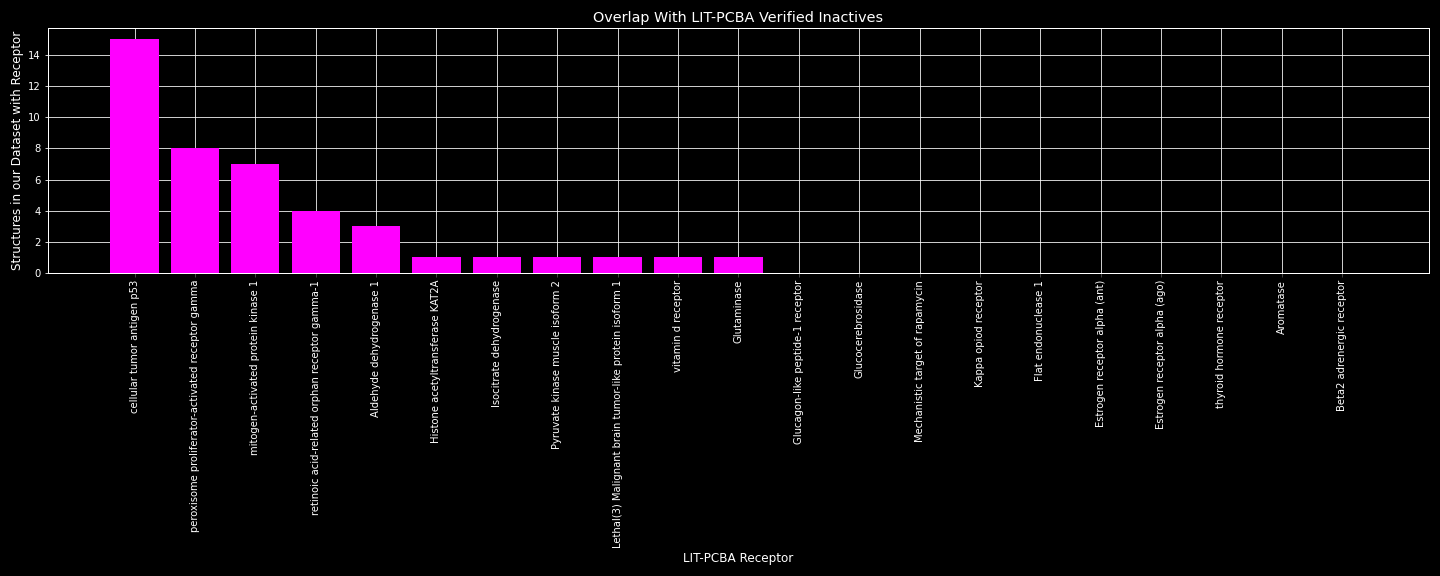

In [20]:
Image('Images/LIT_PCBA_overlap_breakdown.png')

Therefore, moving forward **LIT-PCBA is not being used in this project for experimentally verified inactives, and all decoys will be generated with DeepCoy.**

### **Generating Unbiased Inactives with DeepCoy**

Here, the first step is to convert all of our ligands to .smi or smiles format. For this to go smoothly, we will need to use RDKit to convert the **pdb copies of the ligands to smlies format, not the pdbqt files**. In order to get a working folder of all our ligands in .pdb format, I have written the python script **make_pdb_copies.py**, which is just a simple script to get a list of all the structures in our PDBQT druglike folder, and copy the pdb versions of these from earlier in the project to a working folder that we define:

#### **Running make_pdb_copies.py**

**Arguments**
- **-loc** /path/to/parsed/pdb/structure/folders/
- **-des** /path/to/save/pdb/copies/of/pdbqt/structure/folders/
- **-ref** /path/to/pdbqt/structure/folders/to/get/pdb/copies/of/

An example command line usage would be:
- python3 make_pdb_copies.py -loc /path/to/parsed/pdb/structure/folders/ -des /path/to/save/pdb/copies/of/pdbqt/structure/folders/ -ref /path/to/pdbqt/structure/folders/to/get/pdb/copies/of/

The exact command I used to run this script is as follows (again with newlines added between arguments for clarity):

In [ ]:
# UNIX CODE
python3 make_pdb_copies.py 
-loc /home/milesm/Dissertation/Data/Parsed/Non_redundant/Full_Druglike/ 
-des /home/milesm/Dissertation/Data/PDBQT/Non_redundant/druglike_pdb_copies/ 
-ref /home/milesm/Dissertation/Data/PDBQT/Non_redundant/Druglike/

After we have the pdb copies, we need to convert the ligand.pdb files into ligand.smi files, and then save these in a batch text file for passing to deepcoy. The format is one smile per line in a .smi or .txt file. For this, I've written **smile_generator.py**, which uses RDKit to produce and save ligands in smi format for DeepCoy parsing (producing separate .smi files for batches of ligands defined by the -split argument). It also creates a reference .csv file (smileReferenceSheet.csv) in the directory it's run from for sorting the decoy smile files once they have been produced by DeepCoy. Some of the .pdb ligand files produced by OpenBabel from the PDBBind .mol2 files cannot be parsed by RDKit due to slight differences in the formatting, and so when this happens the script uses the 'backup' file path to try to convert the original mol2 file from the raw pdb data. If there is a problem with this file as well, the structure is ignored and no decoys are generated for that active. As different models are used by DeepCoy to process phosphorous containing ligands vs non-phosphorous containing ligands, the script needs to run twice (once with the -phos flag, once without).

#### **Running smile_generator.py**

**Arguments**
- **-loc** /path/to/pdb/versions/of/pdbqt/structures/
- **-backup** /path/to/pdbbind/raw/data/
- **-phos** boolean - if True, only smiles with phosphates are kept - if False, only smiles with no phosphates are kept
- **-split** int - number of files to split the smiles into for multiprocessing

An example command line usage would be:
- python3 smile_generator.py -loc /path/to/pdb/versions/of/pdbqt/structures/ -backup /path/to/pdbbind/raw/data/ -phos -split 12

The exact command I used to run this script for non-phosphorous ligands is as follows (again with newlines added between arguments for clarity):

In [ ]:
# UNIX CODE
python3 smile_generator.py 
-loc /home/milesm/Dissertation/Data/PDBQT/Non_redundant/druglike_pdb_copies/ 
-backup /home/milesm/Dissertation/Data/Raw/PDBBind/Extracted/refined-set/ 
-split 12

The exact command I used to run this script for phosphorous containing ligands is as follows (again with newlines added between arguments for clarity):

In [ ]:
# UNIX CODE
python3 smile_generator.py 
-loc /home/milesm/Dissertation/Data/PDBQT/Non_redundant/druglike_pdb_copies/ 
-backup /home/milesm/Dissertation/Data/Raw/PDBBind/Extracted/refined-set/ 
-split 4 -phos

#### **Setting up the Remote Server for DeepCoy Processing**

For all the following decoy generation steps, the work was performed on the remote server for this project via command line ssh, the details of which are below:

In [ ]:
# TEXT FILE
NAME="Scientific Linux"
VERSION="7.9 (Nitrogen)"
ID="scientific"
ID_LIKE="rhel centos fedora"
VERSION_ID="7.9"
PRETTY_NAME="Scientific Linux 7.9 (Nitrogen)"
ANSI_COLOR="0;31"
CPE_NAME="cpe:/o:scientificlinux:scientificlinux:7.9:GA"
HOME_URL="http://www.scientificlinux.org//"
BUG_REPORT_URL="mailto:scientific-linux-devel@listserv.fnal.gov"

REDHAT_BUGZILLA_PRODUCT="Scientific Linux 7"
REDHAT_BUGZILLA_PRODUCT_VERSION=7.9
REDHAT_SUPPORT_PRODUCT="Scientific Linux"
REDHAT_SUPPORT_PRODUCT_VERSION="7.9"
Scientific Linux release 7.9 (Nitrogen)
Scientific Linux release 7.9 (Nitrogen)
Scientific Linux release 7.9 (Nitrogen)

Firstly, anaconda3 was installed. Dependencies were installed first:

In [ ]:
# UNIX CODE
sudo yum install libXcomposite libXcursor libXi libXtst libXrandr alsa-lib mesa-libEGL libXdamage mesa-libGL libXScrnSaver

And then anaconda3 downloaded and installed into /home/s1738716/anaconda3:

In [ ]:
# UNIX CODE
wget https://repo.anaconda.com/archive/Anaconda3-2020.11-Linux-x86_64.sh
sha256sum Anaconda3-2020.11-Linux-x86_64.sh

# should output:
>>> cf2ff493f11eaad5d09ce2b4feaa5ea90db5174303d5b3fe030e16d29aeef7de  Anaconda3-2020.11-Linux-x86_64.sh

bash Anaconda3-2020.11-Linux-x86_64.sh

# when asked:
Please answer 'yes' or 'no':'

# typed
>>> yes

# when asked
- Or specify a different location below

# typed
[/root/anaconda3] >>> /home/s1738716/anaconda3

# when asked
Do you wish the installer to initialize Anaconda3
by running conda init? [yes|no]

# typed
[no] >>> yes

Then anaconda was added to path by opening the local .bashrc file from the home directory:

In [ ]:
# UNIX CODE
nano .bashrc

and adding the following line:

In [ ]:
# UNIX CODE
export PATH="/home/s1738716/anaconda3/bin:$PATH"

The ssh session was closed and reopened to resource the .bashrc file, and then DeepCoy cloned into a newly made 'decoyGeneration/DeepCoy' folder:

In [ ]:
# UNIX CODE
mkdir decoyGeneration
cd decoyGeneration
git clone https://github.com/fimrie/DeepCoy.git

Finally, a conda environment was built from the .yml file supplied with DeepCoy, and activated:

In [ ]:
# UNIX CODE
cd DeepCoy
conda env create -f DeepCoy-env.yml
conda activate DeepCoy-env

Now we have a DeepCoy-env python environment on the remote server to make our decoys. To set up DeepCoy, a folder was made for the final decoy output, and the inital prepare_data.py script was run (this took a few hours to complete):

In [ ]:
# UNIX CODE
mkdir final_decoys
cd data
python prepare_data.py

#### **Generating Decoys for Non-Phosphorous Containing Ligands**

To generate the decoys, 12 .smi files were produced with 341 non-phosphorous active smiles in each (0-341 is used as an example throughout). The standard DeepCoy implementation does not accept smiles with phosphorous atoms in, so we will deal with these later with a custom implementation. For non-phosphorous actives, each file was copied from my machine to the remote server (address redacted) using the following command on my machine:

In [ ]:
# UNIX CODE
scp /home/milesm/Dissertation/Code/decoyGenerationAndDocking/np_actives_0-341.txt XXXX@XXXX.XXX.XXX.XX:/home/s1738716/decoyGeneration/DeepCoy/data

Then, the remote server was accessed via ssh and the following commands run to prepare the actives for decoy generation from each batch .smi file:

1. A screen was created for the specific molecule batch file

In [ ]:
# UNIX CODE
screen -S molecules_0-341

2. .smi files were prepared for DeepCoy:

In [ ]:
# UNIX CODE
conda activate DeepCoy-env && cd decoyGeneration/DeepCoy/data
python prepare_data.py --data_path np_actives_0-341.smi --dataset_name np_0-341

3. DeepCoy was executed with the following parameters:

In [ ]:
# UNIX CODE
cd .. && python DeepCoy.py --restore models/DeepCoy_DUDE_model_e09.pickle --dataset zinc --config '{"generation": true, \
                                                                                                    "number_of_generation_per_valid": 1000, \
                                                                                                    "batch_size": 1, \
                                                                                                    "train_file": "data/molecules_np_0-341.json", \
                                                                                                    "valid_file": "data/molecules_np_0-341.json", \
                                                                                                    "output_name": "output/DeepCoy_decoys_np_molecules_0-341.smi", \
                                                                                                    "use_subgraph_freqs": false}'

This process was done for eight batches of molecules at a time, and took around 100 hours for eight batches to run in parallel.

#### **Generating Decoys for Phosphorous Containing Ligands**

Since the default prepare_data.py gives an 'Unknown atom type P5(0)' error for these ligands, I contacted Fergus Imrie (The PhD student who wrote DeepCoy) to confirm how he prepared data for prediction by the phosphorous specific DUDE model. I did not get a reply, but have followed the instructions in the supplementary data and made the following edits to the local copy of the DeepCoy repo on the remote server:

1. The utils.py file was opened in nano text editor

In [ ]:
# UNIX CODE
cd decoyGeneration/DeepCoy
nano utils.py

2. The dataset dictionary on lines 35-41 was edited to add:
- P5(0) to the 'atom_types' list on line 37
- 15:5 to the 'maximum_valence' dictionary on line 38
- 14:'P' to the 'number_to_atom' dictionary on line 39

In [ ]:
# Python - code does not run, but is an example code block of the changes made to utils.py
elif dataset=='zinc':
    return { 'atom_types': ['Br1(0)', 'C4(0)', 'Cl1(0)', 'F1(0)', 'H1(0)', 'I1(0)',
            'N2(-1)', 'N3(0)', 'N4(1)', 'O1(-1)', 'O2(0)', 'S2(0)','S4(0)', 'S6(0)','P5(0)'],
             'maximum_valence': {0: 1, 1: 4, 2: 1, 3: 1, 4: 1, 5:1, 6:2, 7:3, 8:4, 9:1, 10:2, 11:2, 12:4, 13:6, 14:3, 15:5},
             'number_to_atom': {0: 'Br', 1: 'C', 2: 'Cl', 3: 'F', 4: 'H', 5:'I', 6:'N', 7:'N', 8:'N', 9:'O', 10:'O', 11:'S', 12:'S', 13:'S',14:'P'},
             'bucket_sizes': np.array([28,31,33,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,55,58,84])
           }

Once this had been done, the non-phosphorous process was repeated for these .smi files output by smile_generator.py to generate decoys using the **phosphorous specific DUDE model**. All the .smi files were again copied to the remove server via scp (here phosphorous actives 0-155 are used as an example in all the commands):

In [ ]:
# UNIX CODE
scp /home/milesm/Dissertation/Code/decoyGenerationAndDocking/p_actives_0-155.txt XXXX@XXXX.XXX.XXX.XX:/home/s1738716/decoyGeneration/DeepCoy/data

Then on the remote server via ssh:

1. A screen was started for the batch:

In [ ]:
# UNIX CODE
screen -S p_molecules_0-155

2. The DeepCoy-env was activated and the .smi files prepared for the main script:

In [ ]:
# UNIX CODE
conda activate DeepCoy-env && cd decoyGeneration/DeepCoy/data
python prepare_data.py --data_path p_actives_0-155.smi --dataset_name p_0-155

3. DeepCoy was run with the phosphorous model to prepare 1000 decoys for each active:

In [ ]:
# UNIX CODE
cd .. && python DeepCoy.py --restore models/DeepCoy_DUDE_phosphorus_model_e10.pickle --dataset zinc --config '{"generation": true, \
                                                                                                               "number_of_generation_per_valid": 1000, \
                                                                                                               "batch_size": 1, \
                                                                                                               "train_file": \
                                                                                                               "data/molecules_p_0-155.json", \
                                                                                                               "valid_file": "data/molecules_p_0-155.json", \
                                                                                                               "output_name": "output/DeepCoy_decoys_p_molecules_0-155.smi", \
                                                                                                               "use_subgraph_freqs": false}'

#### **Removing Non-Druglike Decoys from Evaluation**

Once the phosphorous and non-phosphorous batches were complete, generated decoys needed screening for number of rotatable bonds. As there is no cap on this for DeepCoys generated molecules, they could contain more rotatable bonds than the active, giving rise to decoys with > 13 rotatable bonds. As this number is a feature we want to give to the model, having decoys over this threshold would introduce a significant source of bias. Therefore, generated decoys were filtered and those with more than 13 rotatable bonds removed before evaluation using **druglike_screen_generated_decoys.py**. This produces new .smi files in the folder **screened_output/** for evaluation which are stripped of biased decoys.

#### **Running druglike_screen_generated_decoys.py**

**Arguments**
- **-num_rots** int(upper limit for number of rotatable bonds in decoy)

This script is designed to be run within the DeepCoy folder on the remote server, and I ran it as follows in the DeepCoy-env conda environment:

In [ ]:
# UNIX CODE
python druglike_screen_generated_decoys.py -num_rots 13

#### **Evaluating Generated Decoys to Select Best 15**

The 15 best decoys were then selected from remaining generated decoys using the protocol below:

1. A working copy of the 'screened_output' folder was made to reduce the risk of accidentally corrupting/deleting the produced decoys, as these took a very long time to produce:

In [ ]:
# UNIX CODE
mkdir working_output
cp ./screened_output/*.smi ./working_output

2. The decoys were evaluated using DeepCoys '**select_and_evaluate_decoys.py**' script:

In [ ]:
# UNIX CODE
cd evaluation
python select_and_evaluate_decoys.py --data_path  /home/s1738716/decoyGeneration/DeepCoy/working_output/ --output_path /home/s1738716/decoyGeneration/DeepCoy/final_decoys/ --dataset_name dude_ext --num_decoys_per_active 15 --min_active_size 1 --num_cores 16 --min_num_candidates 10 >> decoy_selection_log.txt

3. The results file was moved into a newly made **metrics** folder to leave only the selected decoys in the **final_decoys** folder:

In [ ]:
# UNIX CODE
cd -
mkdir metrics
mv ./final_decoys/results.csv ./metrics

4. **From my machine**, the results.csv file was fetched for inspection using scp:

In [ ]:
# UNIX CODE
scp XXXXXX@XXXXXXX:/home/s1738716/decoyGeneration/DeepCoy/metrics/results.csv /home/milesm/Dissertation/Code/decoyGenerationAndDocking/decoyResults

#### **Verifying Evaluation of Decoys**

When inspecting the .smi files produced by DeepCoy's select_and_evaluate_decoys.py script, some actives had less than 15 decoys selected for them (several had none selected and had been omitted from the final_decoys/.smi file). These actives were always located at the very end of the output file, indicating a possible bug that cuts off the outputted selected decoys for the last active in the batch. In order to ensure that sufficient decoys were generated for all actives, I wrote a script to count the number of selected decoys present for each active. All actives with less than 15 decoys have their original 1000 generated decoys scraped from the raw DeepCoy output files and written to a new .smi file **in the evaluation/ folder called re_evaluate_decoys.smi.** **This file contains the original 1000 generated decoys for every active that had less than 15 decoys present post-evaulation.** This .smi file was then evaluated again with select_and_evaluate_decoys.py to attempt to pick the best 15 again. The limited number of decoys initially selected for these actives were manually deleted from their .smi files in final_decoys/.

#### **Running verify_decoys.py**

**No Arguments**

This script is designed to be run within the DeepCoy folder on the remote server, and I ran it as follows in the DeepCoy-env conda environment:

In [ ]:
# UNIX CODE
python /home/s1738716/decoyGeneration/DeepCoy/verify_decoys.py

After running this, the decoys were re-evaluated using select_and_evaluate_decoys.py with the following command:

In [ ]:
# UNIX CODE
python select_and_evaluate_decoys.py --data_path  re_evaluate_decoys.smi --output_path /home/s1738716/decoyGeneration/DeepCoy/final_decoys/ --dataset_name dude_ext --num_decoys_per_active 15 --min_active_size 1 --num_cores 16 --min_num_candidates 10 >> decoy_reselection_log.txt

### **Docking DeepCoy Generated Decoys**

This step is also performed on the remote server in the DeepCoy-env. We now have multiple DeepCoy produced .smi files in the format of {active_smile} {decoy_smile}\n as below (with 15 decoys for each active):

In [ ]:
# SMI FILE
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 C=C1COCC=C1C(=O)NNC(=O)COC(=O)C1CSC(=S)S1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 COS(=O)(=O)C1=C2NC(=O)NCCC=CCC(=O)C=C2CS1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 O=CC=C(C=C1SCC(=O)NC1=S)S(=O)(=O)NC1=CCOC=C1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 Cc1cc2c(=O)[nH]c(=O)sc2c(=O)n1Cc1ccc([SH](=O)=O)s1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CCNS(=O)(=O)C1=CC(=O)C(SC)=CC1=C1SC(=O)N(C)C1=O
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CC=C1SC(SC2CCS(=O)(=O)C2)=C(C(=O)NC)C(=O)NC1=O
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CC(=O)C1=CNC(=CSC(=S)N[SH](=O)=O)C(C(=O)OC(C)C)=C1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CS(=O)(=O)C1CCC(NC(=O)NC2=CC=CSC2[SH](=O)=O)CC1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CSc1cc(S)ccc1OC(=O)Nc1cc([SH](=O)=O)c[nH]c1=O
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 COC(=O)C1=CC(=O)C=C(C)SC(=S)NC(=O)SC(C)C(=O)N1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 O=C1C=C(NC(=O)C(=O)NC(=O)Sc2cccs2)C(=CCO)S1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CC=C(S)C1=C(NC(=O)OCC(=O)OC)C(=CC(=S)S)C(=O)N1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CCOC(=O)N(C)C(=O)C(=O)NC(=CC(=O)SC)C1SC=CS1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 CNc1cccc(OC(=O)NC(=S)SC2C(=O)OCCS2=O)c1
COc1cccc(N2CCc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1 COC(=O)Cn1c2c(c(=O)[nH]c1=S)C(C)C1=C(S2)S(=O)(=O)CC1

These smile decoys need converting into 3D structure pdb files, and then these pdb files need converting into pdbqt files with AutoDockTools in exactly the same way as our actives. Finally, these pdbqt decoys need docking into the active crystal receptor.pdbqt files. They can then be added to our full dataset of druglike ligand and receptor pdbqt structures for batch scoring with binana.py. To automate this, I've written a script called **rapid_docker.py**, which takes a folder of .smi files as input, and creates pdb and pdbqt versions of all decoys named as '{pdb_code}_decoy_X.pdbqt' where X is a number between 1 and 15 to differentiate the decoy from others for that active. It then docks these pdbqt versions of the decoys to the respective receptor using GWOVina and outputs the docked decoy and receptor files in a user supplied destination folder.

In order to run this on the remote server, we need to add GWOVina, AutoDockTools and our PDBQT actives data to it. For this:

 1. A folder was made in the remote server home directory

In [ ]:
# UNIX CODE
mkdir decoyDocking

2. /home/milesm/Dissertation/Data/PDBQT/Non_redundant/Druglike was compressed to a tar.xz archive and copied to this folder using scp then extracted:

In [ ]:
# UNIX CODE
scp /home/milesm/Dissertation/Data/PDBQT/Non_redundant/Druglike_pdbqts_for_server.tar.xz XXXXX@XXXXX:/home/s1738716/decoyDocking
tar -xf /home/s1738716/decoyDocking/Druglike_pdbqts_for_server.tar.xz

3. Boost was installed on the remote server using the following commands:

In [ ]:
# UNIX CODE
sudo yum install boost-devel

4. The GWOVina tarball file was copied to the remote server and the installation process above repeated:

In [ ]:
# UNIX CODE
scp /home/milesm/Dissertation/Third_Party_Code/gwovina-1.0.tar.gz XXXXX@XXXXX:/home/s1738716/decoyDocking
# install with same commands from software installations

5. The XGBScore github was cloned into the **home directory** of the remote server:

In [ ]:
# UNIX CODE
git clone https://github.com/miles-mcgibbon/XGBScore.git

6. AutoDockTools was installed on the remote server using the same commands as previously:

In [ ]:
# UNIX CODE
wget mgltools.scripps.edu/downloads/downloads/tars/releases/REL1.5.6/mgltools_x86_64Linux2_1.5.6.tar.gz
cd mgltools_x86_64Linux2_1.5.6
sudo ./install.sh

7. The reference .csvs produced by smile_generator.py were copied to the remote server using scp:

In [ ]:
# UNIX CODE
scp /home/milesm/Dissertation/Code/decoyGenerationAndDocking/noPhosphorousSmileReferenceSheet.csv XXXXX@XXXXX:/home/s1738716/decoyDocking
scp /home/milesm/Dissertation/Code/decoyGenerationAndDocking/phosphorousSmileReferenceSheet.csv XXXXX@XXXXX:/home/s1738716/decoyDocking

8. The DeepCoy-env conda enviroment is activated again (we're using this as most of the libraries the script uses are already installed in this environment):

In [ ]:
# UNIX CODE
conda activate DeepCoy-env

9. From the decoyDocking folder, the csvs were combined into one using the following python code snipped executed line by line in the terminal:

In [ ]:
# UNIX CODE
cd decoyDocking

In [ ]:
# Python code for running line by line on the remote server conda env interpreter
import pandas as pd
noPhos = pd.read_csv('noPhosphorousSmileReferenceSheet.csv')
phos = pd.read_csv('phosphorousSmileReferenceSheet.csv')
master_df = phos.append(noPhos)
master_df.to_csv('masterSmileReferenceSheet.csv')

9.  Any missing libraries were installed:

In [ ]:
# UNIX CODE
python -m pip install biopandas==0.2.7 tqdm

Then rapid_docker.py is executed as below

#### **Running rapid_docker.py**

**Arguments**
- **-dock** /path/to/gwovina/executable/
- **-ref** /path/to/reference/csv/produced/by/smile_generator.py/
- **-pdbqts** /path/to/pdbqt/structure/folders/from/pdbqt_batch_converter.py/
- **-decoys** /path/to/folder/containing/DeepCoy/smiles/output.smi/files/
- **-des** /path/to/save/docked/decoys/and/receptor/pdbqts
- **-mgl** /path/to/mgl_tools/root/directory/
- **-pad** int(angstrom padding to add docking search space)

An example command line usage would be:
- python rapid_docker.py - -dock /path/to/gwovina/executable -ref /path/to/reference/csv/produced/by/smile_generator.py -pdbqts /path/to/pdbqt/structure/folders/from/pdbqt_batch_converter.py -decoys /path/to/folder/containing/DeepCoy/smiles/output.smi/files -des /path/to/save/docked/decoys/and/receptor/pdbqts --mgl /path/to/mgl_tools/root/directory/ -pad int(angstrom padding to add docking search space)

The exact command I used to execute this (with newlines added for clarity) is below:

In [ ]:
# UNIX CODE
python rapid_docker.py 
-dock /home/s1738716/decoyDocking/gwovina-1.0/build/linux/release/gwovina 
-ref /home/s1738716/decoyDocking/masterSmileReferenceSheet.csv 
-pdbqts /home/s1738716/decoyDocking/Druglike/ 
-decoys /home/s1738716/decoyGeneration/DeepCoy/final_decoys/ 
-des /home/s1738716/decoyDocking/dockedDecoys/ 
-mgl /home/s1738716/decoyDocking/mgltools_x86_64Linux2_1.5.6/
-pad 12

Once rapid_docker.py had finished docking, the resultant docked decoy.pdbqt and receptor.pdbqt files were compressed to a tar.gz archive:

In [ ]:
# UNIX CODE
tar -czvf /home/s1738716/decoyDocking/dockedDecoys.tar.gz /home/s1738716/decoyDocking/dockedDecoys/

And copied to my local machine using SCP:

In [ ]:
# UNIX CODE
scp XXXXXXX@mXXXXXXXX:/home/s1738716/decoyDocking/dockedDecoys.tar.gz /home/milesm/Dissertation/Data/PDBQT/Non_redundant/

Then extracted:

In [ ]:
# UNIX CODE
tar -xf /home/milesm/Dissertation/Data/PDBQT/Non_redundant/dockedDecoys.tar.gz

<a id='collating_final_dataset'></a>
# **Collating Final Dataset**

## Software Installations

#### **Python libraries**

Python libraries for this section were installed using pip:

In [ ]:
# UNIX CODE
python3 -m pip install xlrd

### **Collating and Standardising Binding Data**

As our structures are from three different datasets, we need to collate the binding data into one place for all of our structures, in the same format **(Kd/Ki in uM)**. For each database (Iridium, PDBBind, Binding MOAD) the data is stored in a different format, layout and concentration. Therefore, I have written the script **fetch_binding_data.py** to collect the binding data from the database each structure is from, and produce a master dataframe (**convertedBindingData.csv**) for our dataset with the raw structures. This program:

- Fetches binding data for all structures where it is present
- Converts the binding data to uM concentration
- Filters out CC50 and unclear IC50 values
- Classifies the binding data with a 1 or 0 based on Kd/Ki being lower or higher than 25uM
- Gives the option to make a copy of the input dataset where structures with no binding data are removed named {input_folder_name}_filtered_binding_data

#### **Dealing with IC50 Values in the Dataset**

Kd/Ki is **estimatable** from IC50 values via the Cheng–Prusoff equation:

$$
Ki = \frac{IC_{50}}{1+\frac{[S]}{K_{m}}}
$$

However, calculating these estimations would require manual determination of both ligand concentration **_[S]_** and Michaelis constant **_Km_** for over 450 protein-ligand interactions through a primary literature search. As the timeframes of this project do not permit this, the following assumptions were made to classify IC50 values with a 25uM Kd/Ki threshold:

1. As the denominator of the Cheng-Prusoff equation is a value greater than 1, the Ki estimated will be smaller than the stated IC50 value. Therefore any IC50 value lower than 25uM is given a class label of 1
2. As a high substrate concentration and low Michaelis constant could significantly decrease the estimated Ki value in comparison with the IC50 value, protein-ligand complexes with an IC50 between 25uM and 250uM have been excluded from the dataset. Therefore, any structure with an IC50 of greater than 250uM is given a class label of 0.

#### **Running fetch_binding_data.py**

**Arguments**
- **-irid** /path/to/iridium/data/sheet/Iridium_DOI_DPI_RES.xls
- **-pdb** /path/to/pdb/bind/index/data/sheet/INDEX_refined_data.2019
- **-moad** /path/to/moad/data/sheet/nr_bind.csv
- **-pdbqt** /path/to/pdbqt/structure/folders/from/pdbqt_batch_converter.py/
- **-threshold** int(threshold for class label, with lower being given a class label of 1, and above 0)
- **-out** /path/to/output/convertedBindingData.csv

An example command line usage would be:
- python3 fetch_binding_data.py -irid /path/to/iridium/data/sheet/Iridium_DOI_DPI_RES.xls -pdb /path/to/pdb/bind/index/data/sheet/INDEX_refined_data.2019 -moad /path/to/moad/data/sheet/nr_bind.csv -pdbqt /path/to/pdbqt/structure/folders/from/pdbqt_batch_converter.py/ -threshold int(threshold for class label, with lower being given a class label of 1, and above 0) -out /path/to/output/convertedBindingData.csv

The exact command I used to execute this (with newlines added for clarity) is below:

In [ ]:
# UNIX CODE
python3 fetch_binding_data.py 
-irid /home/milesm/Dissertation/Data/Raw/Iridium/Iridium/Iridium_DOI_DPI_RES.xls 
-pdb /home/milesm/Dissertation/Data/Raw/PDBBind/Extracted/refined-set/index/INDEX_refined_data.2019 
-moad /home/milesm/Dissertation/Data/Raw/Binding_MOAD/Compressed/nr_bind.csv
-pdbqt /home/milesm/Dissertation/Data/PDBQT/Non_redundant/Druglike
-threshold 25
-out /home/milesm/Dissertation/Data/convertedBindingData.csv

This gave the following output:

In [ ]:
# TERMINAL OUTPUT
Checking for CC50 values...
File contains CC50 values
Removing...
All CC50 values:

PDBCode BindingDataType BindingValue BindingUnits Database
15    1c1b            CC50         52.5           uM  Iridium
Converting units...

Filtering out IC50 values between 25.0 uM and 250.0 uM...
1 structure(s) with CC50 values:
['1c1b']
29 structure(s) do not meet IC50 value requirements:
['1b9v', '3ond', '1k3t', '2dm6', '2vtd', '6djj', '2j83', '4mob', '5hmr', '4lh7', '2vl8', '2pt9', '2bnf', '5jdc', '6gcl', '5k6a', '1yhm', '6n69', '4w9n', '2bve', '5tuf', '6phr', '3qsb', '5lx6', '5mrh', '4lqy', '4u31', '2boi', '3cv6']
11 structure(s) have no binding data present:
['1g9v', '1sq5', '1pbd', '1gm8', '1u4d', '1rob', '1p62', '1ukz', '1r9o', '1unl', '4aah']
Make copy of dataset without these structures? (y/n)
>>> y

The 'make copy without these structures' option was used to make a new dataset with only copies of structures with binding data containing 4,694 structures.

### **Adding Docked Decoys to Dataset**

Since some ligands in the structures contained atom types unsupported by DeepCoy, decoys could not be generated for them. To remove the bias attached to ligands containing these atom types as good binders, these structures with no decoys need to be removed from the dataset.

It was also discovered upon docking that some structures in the downloaded datasets had **multiple possible positions for amino acid side chains in the receptor structure**. This causes a specific error when trying to dock any files to the receptor, and therefore decoys could not be docked. Moreover, we want to exclude these structures from our dataset entirely, as it could severely affect model performance.

Therefore, we need to construct a new dataset in a new folder which contains actives structures that:

1. Have binding data that is suitable to be classified (Ki/Kd value, most IC50 values that aren't within the exclusion range of 25uM - 250uM)
2. Have sufficient (15) decoys present
3. Do not have multiple possible positions for amino acid side chains in the receptor structure
4. Do not have ligands that contain atom types unsupported by DeepCoy

**When evaluating decoys, DeepCoy only selected 13 to 14 decoys for a small handful of structures (4). Since DeepCoy could not find 15 suitable decoys for these actives, the active and selected 13 or 14 decoys have been included in the final dataset.**

To construct this dataset, I have written a script called **build_decoyed_dataset.py**. This does the following:

1. Removes any empty folders in dockedDecoys that arise from GWOVina docking errors after the directory for output has been made
2. Counts how many docked decoys are present for each active structure and saves the output as a dataframe to **actives_decoy_sumary.csv**
3. Gives the option to create a new folder containing all actives with more than a user specified threshold number of decoys present in the dockedDecoys folder
4. Gives the option to copy all the decoys for **only these actives** into the same folder to create a full dataset to use for feature engineering

#### **Running build_decoyed_dataset.py**

**Arguments**
- **-decoys** /path/to/docked/decoys/
- **-pdbqts** /path/to/active/pdbqts/with/binding/data/
- **-decoy_thresh** int(minimum number of decoys needed for an active to be included)

An example command line usage would be:
- python3 build_decoyed_dataset.py -decoys /path/to/docked/decoys/ -pdbqts /path/to/active/pdbqts/with/binding/data/ -decoy_thresh int(minimum number of decoys needed for an active to be included)

The exact command I used to execute this (with newlines added for clarity) is below:

In [ ]:
# UNIX CODE
python3 build_decoyed_dataset.py -decoys /home/milesm/Dissertation/Data/PDBQT/Non_redundant/dockedDecoys/ -pdbqts /home/milesm/Dissertation/Data/PDBQT/Non_redundant/Druglike_filtered_binding_data/ -decoy_thresh 13

This gave the following output:

In [ ]:
# TERMINAL OUTPUT
Found 276 structures with less than 13 decoys present:
Make copy of dataset without these structures under Druglike_filtered_binding_data_with_decoys? (y/n)
>>>y
Copying structures...
Copy decoys into this dataset? (y/n)
>>>y

Overall, **fetch_binding_data.py** and **build_decoyed_dataset.py** filtered 287 structures from the dataset, leaving 4,418 actives and 66,264 decoys in the final dataset for scoring function training and testing.

<a id='feature_extraction'></a>
# **Feature Extraction**

## Software Installations

#### **Python libraries**

Python libraries for this section were installed using pip:

python3 -m pip install scipy

Once a master dataset of active and docked decoy pdbqt files has been produced, each protein.pdbqt and ligand.pdbqt needs to have features extracted from it. Two separate sets of features will be extracted from each protein-ligand complex:

- 1540 Extended Connectivity Interaction Features (ECIFs) using code from the GitHub referenced in the publication: https://doi.org/10.1093/bioinformatics/btaa982
- 525 features generated by BINANA.py produced by the Durrant Lab: https://doi.org/10.1016/j.jmgm.2011.01.004

### **Calculating ECIFs**

Functions from the [DIFACQUIM GitHub](https://github.com/DIFACQUIM/ECIF) were compiled into the python script **ecif_utils.py**. To match the authors methods of ECIF calculation, pdbqt ligands needed to be converted to sdf format with all hydrogens added. The script **calculate_ecifs.py** performs the pdbqt to sdf conversion for all ligands, then uses functions from **ecif_utils.py** to extract the ECIFs present in the ligand-protein interaction, and writes the result to a .csv file. This script also needs .pdb copies of the receptor file as input, so the folder containing pdb copies of our dataset constructed by **make_pdb_copies.py** is given a one of several arguments.

#### **Running calculate_ecifs.py**

**Arguments**
- **-pdbqts** /path/to/pdbqt/final/dataset/
- **-pdbs** /path/to/pdb/versions/of/pdbqts/
- **-out** /filepath/to/save/ecif/results.csv

An example command line usage would be:
- python3 calculate_ecifs.py -pdbqts /path/to/pdbqt/final/dataset/ -pdbs /path/to/pdb/versions/of/pdbqts/ -out /filepath/to/save/ecif/results.csv

The exact command I used to execute this (with newlines added for clarity) is below:

In [ ]:
# UNIX CODE
python3 /home/milesm/Dissertation/Code/featureEngineering/calculate_ecifs.py 
-pdbqts /home/milesm/Dissertation/Data/PDBQT/Non_redundant/Druglike_filtered_binding_data_with_decoys/ 
-pdbs /home/milesm/Dissertation/Data/PDBQT/Non_redundant/druglike_pdb_copies/ 
-out /home/milesm/Dissertation/Data/Features/EFICs/ecif_data.csv

### **Calculating BINANA Features**

BINANA.py produces the following types of features to characterise the protein-ligand interaction:
- Atom-type pair counts within 2.5 angstroms
- Atom-type pair counts within 4.0 angstroms
- Ligand atom types
- Summed electrostatic energy by atom-type pair, in J/mol
- Number of rotatable bonds in the ligand
- Active-site flexibility
- Hydrogen bonds
- Hydrophobic contacts (C-C)
- pi-pi stacking interactions
- T-stacking (face-to-edge) interactions
- Cation-pi interactions
- Salt Bridges

Binana features for each complex were calculated using **batch_binana.py**, a custom written batch implementor of **BINANA.py**, producing one text file of features for each ligand.pdbqt and receptor.pdbqt pair. These text files of features are then parsed into a dataframe by the custom script **binana_parser.py** and saved as **all_binana_data.csv**.

#### **Running batch_binana.py**

**Arguments**
- **-binana** /path/to/BINANA.py
- **-loc** /path/to/pdbqt/dataset/
- **-suc** /path/to/save/successful/text/files/
- **-prob** /path/to/save/problem/text/files/
- **-threads** int(number of threads to parallelise process over)

An example command line usage would be:
- python3 batch_binana.py -binana /path/to/BINANA.py -loc /path/to/pdbqt/dataset/ -suc /path/to/save/successful/text/files/ -prob /path/to/save/problem/text/files/ -threads int(number of threads to parallelise process over)

The exact command I used to execute this (with newlines added for clarity) is below:

In [ ]:
# UNIX CODE
python3 /home/milesm/Dissertation/Code/featureExtraction/batch_binana.py 
-binana /home/milesm/Dissertation/Third_Party_Code/binana.py 
-loc /home/milesm/Dissertation/Data/PDBQT/Non_redundant/Druglike_filtered_binding_data_with_decoys/ 
-suc /home/milesm/Dissertation/Data/Features/binana/successes/
-prob /home/milesm/Dissertation/Data/Features/binana/problems/
-threads 4

#### **Running binana_parser.py**

**Arguments**
- **-loc** /path/to/successful/text/files/
- **-out** /path/to/save/all_binana_data.csv

An example command line usage would be:
- python3 binana_parser.py -loc /path/to/successful/text/files/ -out /path/to/save/all_binana_data.csv

The exact command I used to execute this (with newlines added for clarity) is below:

In [ ]:
# UNIX CODE
python3 binana_parser.py 
-loc /home/milesm/Dissertation/Data/Features/binana/successes/ 
-out /home/milesm/Dissertation/Data/Features/binana/all_binana_data.csv

### **Combining Features and Binding Data**

To produce the master dataset of features, the .csv files **ecif.csv**, **convertedBindingData.csv** and **all_binana_data.csv** were combined using the following python code:

In [ ]:
# PYTHON CODE
import pandas as pd

# read in the dataframes
binana = pd.read_csv("/home/milesm/Dissertation/Data/Features/binana/all_binana_data.csv")
ecif = pd.read_csv("/home/milesm/Dissertation/Data/Features/EFICs/ecif_data.csv")
binding = pd.read_csv("/home/milesm/Dissertation/Data/convertedBindingData.csv")

# standardise structure names
binana['PDBCode'] = binana['Name'].apply(lambda x: x.replace('_ligand',''))

# merge into one dataframe
final_df = ecif.merge(binana, how="left",on=["PDBCode"])
final_df = final_df.merge(binding, how="left",on=["PDBCode"])

# drop redundant name column
final_df = final_df.drop(["Name"],axis=1)

# deal with missing values for decoy structures
final_df["Label"].fillna(0,inplace=True)
final_df["BindingValue"].fillna(1e+6,inplace=True)
final_df["Binding_Data_in_uM"].fillna(1e+6,inplace=True)
final_df["BindingDataType"].fillna("Decoy",inplace=True)
final_df["BindingUnits"].fillna("Decoy",inplace=True)
final_df.sort_values(by="PDBCode",inplace=True)
final_df["Database"].ffill(inplace=True)

# save as hdf5 for speed of saving and loading of large dataframe
final_df.to_hdf("/home/milesm/Dissertation/Data/final_df.h5",key="df",mode="w")

Note that the data is saved as an .h5 file in .hdf5 format for loading speed and preservation of column data types.

<a id='splitting_the_data'></a>
# **Splitting The Data**

## Software Installations

#### **Python libraries**

Python libraries for this section were installed using pip:

In [ ]:
# UNIX CODE
python3 -m pip install pypdb sklearn matplotlib

Before feature engineering, we must separate a test set that is not involved in any feature selection or dimensionality reduction techniques. To ensure this test set is representative and fair for evaluation of our scoring function, the following approach was taken:

1. Resolutions of active structures were added by querying the PDB api using pypdb and binned into six groups:

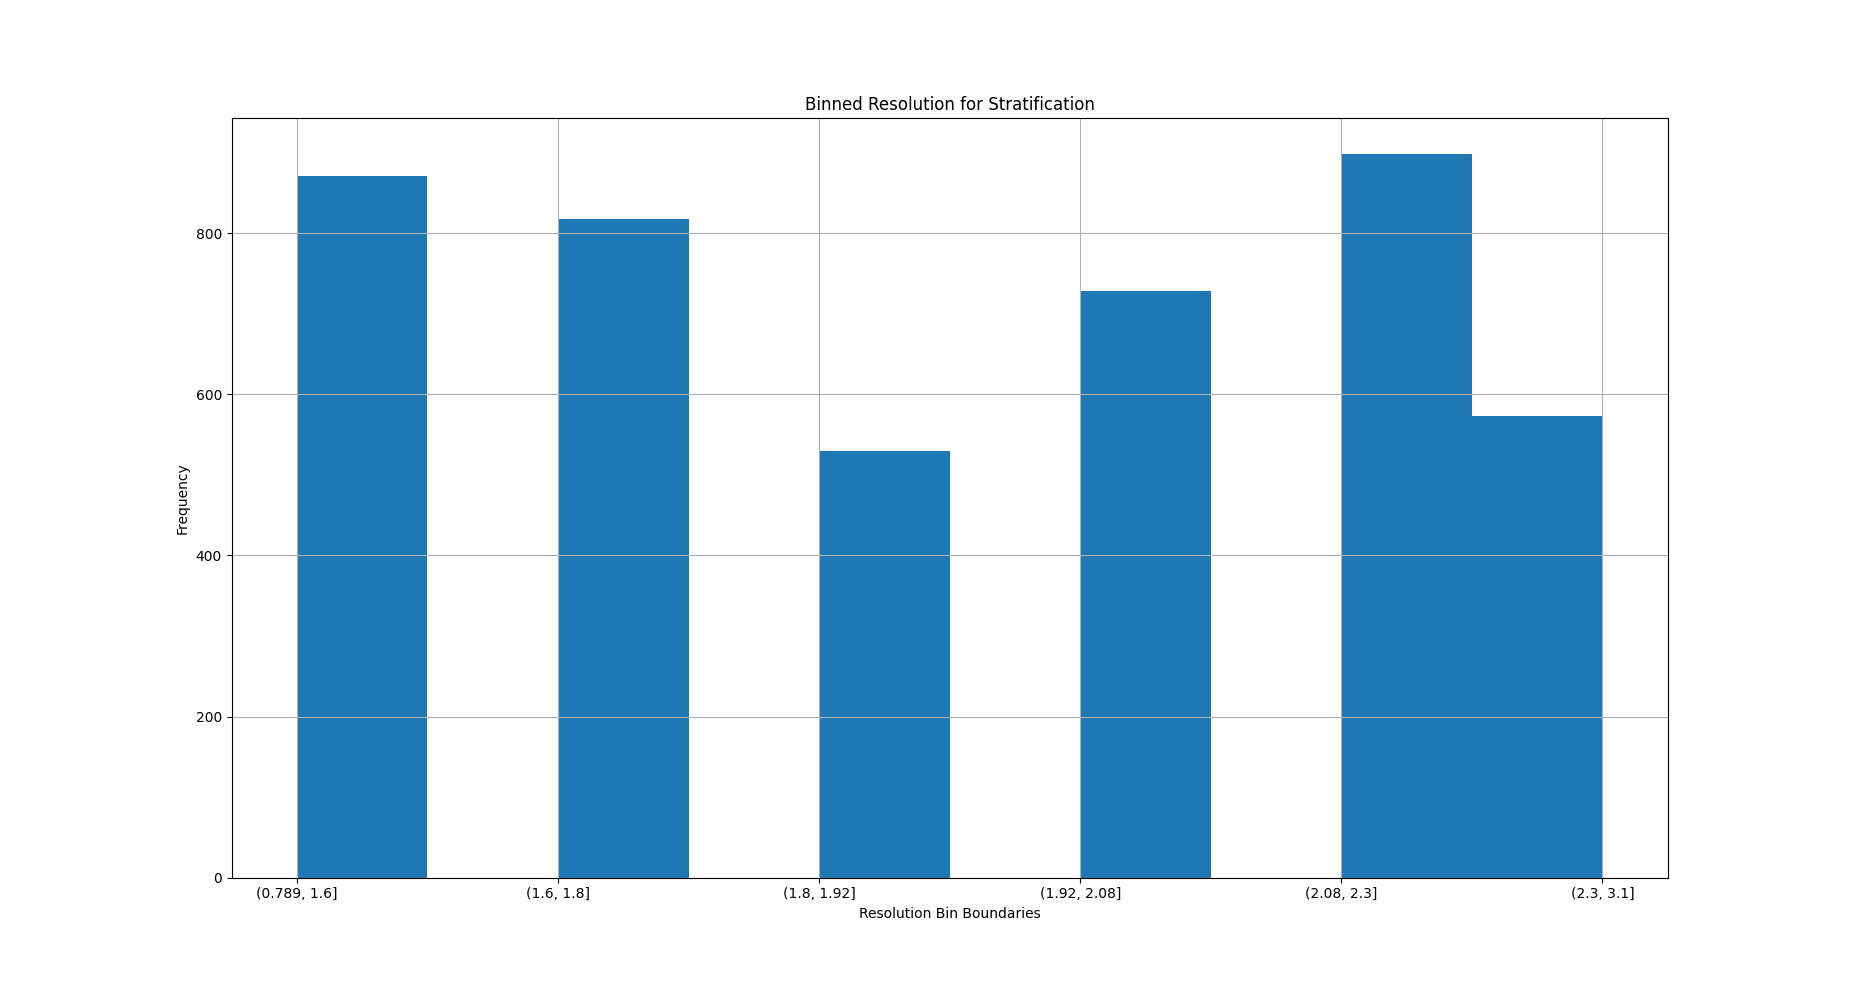

In [2]:
Image('Images/resolution_data_binned.png')

2. Binding data in uM was also binned into six groups:

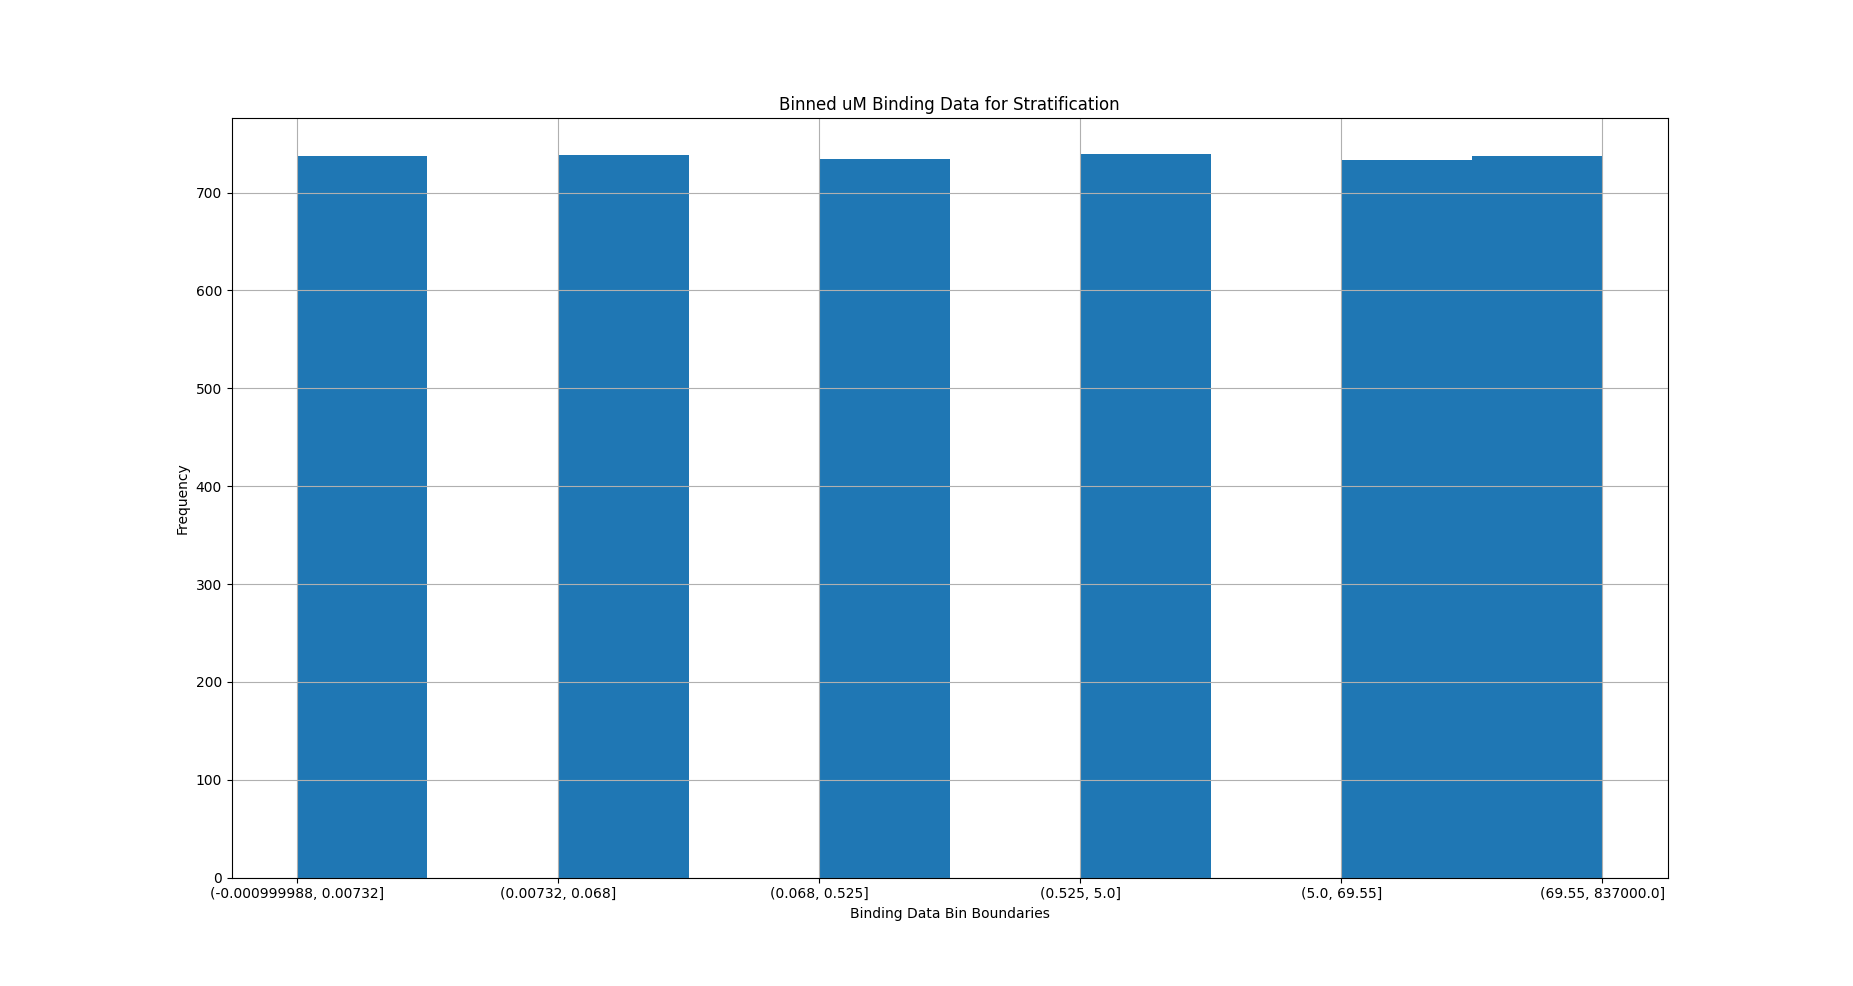

In [4]:
Image('Images/binding_data_bins.png')

3. Label frequencies were examined:

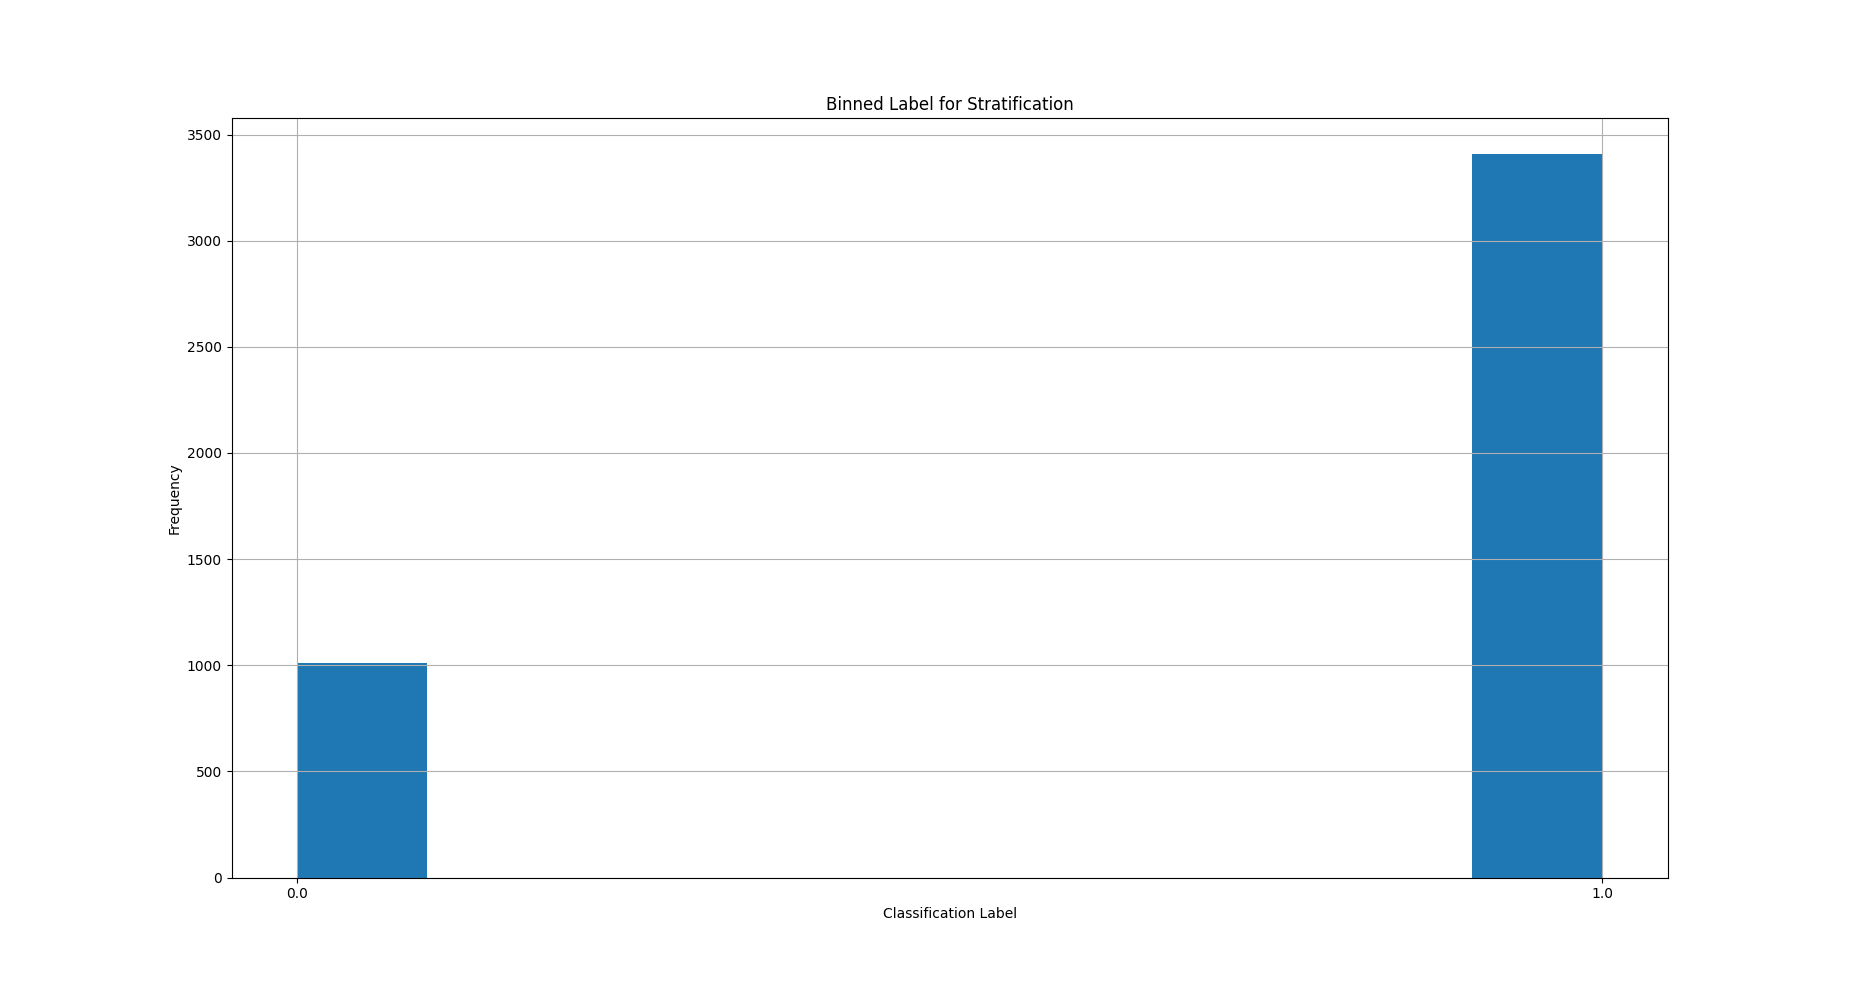

In [5]:
Image('Images/label_binned_strat.png')

4. 5% of actives were randomly selected using sklearn's StratifiedShuffleSplit function **containing the same frequency of resolution, binding data and label class groups as the overall dataset**. 
5. These actives and their decoys were saved as the test set, and saved on an external drive. Remaining actives and their decoys were saved as the training set for feature engineering.

The script that performs this splitting is called **split_train_and_test.py**.

#### **Running split_train_and_test.py**

**Arguments**
- **-data** /path/to/h5/master/dataset.h5
- **-out** /filepath/to/save/training/and/test/sets/
- **-test_frac** float(fraction of data to separate as the test set)

An example command line usage would be:
- python3 split_train_and_test.py -data /path/to/h5/master/dataset.h5 -out /filepath/to/save/training/and/test/sets/ -test_frac float(fraction of data to separate as the test set)

The exact command I used to execute this (with newlines added for clarity) is below:

In [ ]:
# UNIX CODE
python3 split_training_and_test.py 
-data /home/milesm/Dissertation/Data/final_df.h5 
-out /home/milesm/Dissertation/Data/ 
-test_size 0.05

<a id='feature_engineering'></a>
# **Feature Engineering**

## Software Installations

#### **Python libraries**

Python libraries for this section were installed using pip:

In [ ]:
## UNIX CODE
python3 -m pip install sklearn joblib matplotlib

### **General Approach**

All feature engineering was performed on the **training set only** to prevent feature selection bias. The feature engineering approach involved several steps outlined below in order to produce a final set of optimal features for training the scoring function.

1. Removing features with zero variance
2. Removing heavily co-correlated features
3. Scaling the data
4. Removing unimportant features 
5. PCA/Dimensionality Reduction

### **Removing Features with Zero Variance**

Variance for each column of the dataframe was calculated using pandas's df.var() function, and columns with zero variance recorded and subsequently dropped. This was performed by **strip_features_and_standardise.py**.

### **Removing Heavily Co-correlated Features**

To do this, pairwise pearson correlations and pearson correlations to the target classification label were calculated for all features. Pairs of features with a pearson correlation of greater than 0.9 were recorded. In each pair, the feature with the lowest pearson correlation to the target classification label was dropped. This was also performed by **strip_features_and_standardise.py**.

### **Scaling the Data**

Data was scaled columnwise to standardise all values in the dataset to between -1.0 and 1.0. sklearn's **MaxAbsScaler()** was used for scaling as this preserves the sparsity of our data, while scaling non-zero values to within the afforementioned range by dividing by the maximum value in the feature column. This is the final function performed by **strip_features_and_standardise.py**.